In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
from itertools import chain
import glob
import seaborn as sns
import matplotlib.font_manager as font_manager
import seaborn as sns
import matplotlib as mpl
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import SGDRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from collections import Counter
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import register_matplotlib_converters
import warnings
import itertools
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
register_matplotlib_converters()

In [4]:
sns.set_theme()
mpl.matplotlib_fname()
font_dirs = ['D:\\Software\\Anaconda\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf' ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
mpl.font_manager._rebuild()
result = font_manager.findfont("Rounded Mplus 1c")
print(result)
mpl.rc('font', family='Rounded Mplus 1c')

D:\Software\Anaconda\Lib\site-packages\matplotlib\mpl-data\fonts\ttf\MPLUSRounded1c-Regular.ttf


In [5]:
def extract_engine_data (description, list_em):
    engine_model = []
    for e in list_em:
        em_reg = re.findall(r'\b{}-\w+-?\w*\b'.format(e), description)
        if len(em_reg) != 0 :
          em_reg = map(lambda x : x.split('-')[0],em_reg)
#           em_reg = list(set(em_reg)) 
          engine_model.append(em_reg)
    if len(engine_model) != 0:
      return list(chain(*engine_model))
    else: 
      return 0

def normalize_zero (row,unit_price):
    if row['Quantity'] == 0:
      if row['Cargo Value USD'] % unit_price < 2:
        return 1
      else:
        return row['Cargo Value USD'] // unit_price
    else:
        return row['Quantity']
    

def check_count_em (row,unit_price):
    if (row['count_em'] == 1) and (row['len_em'] > 1):
       if (row['Cargo Value USD'] < unit_price) or (row['Cargo Value USD'] == unit_price):
         return  round(row['Cargo Value USD']/row['len_em'],2)
       else:
         return unit_price

    elif (row['count_em'] > 1) and (row['len_em'] > 1):
        if (row['Cargo Value USD'] < row['count_em'] * unit_price) or (row['Cargo Value USD'] == row['count_em'] * unit_price):
           return  round(row['Cargo Value USD']/row['Quantity'],2)
#         elif row['Cargo Value USD'] > row['count_em'] * 266.77
#              return  round(row['Cargo Value USD']/row['len_em'],2)
        else:
            return row['count_em'] * unit_price
#             return  round(row['Cargo Value USD']/row['Quantity']*row['count_em'],2)
    elif ((row['count_em'] ==1) and (row['len_em'] == 1)):
       return  round(row['Cargo Value USD']/row['len_em'],2)
    else:
       return row['Cargo Value USD']



def count_length(list_em,em):
    count  = 0
    for i in list_em:
        if i == em:
            count+=1
    return count

In [6]:
# Load list all engine model in GTO
# df_merged = read_csv('list_all_em_GTO.csv',parse_dates=['Register Date'])
df_merged = read_csv('list_all_em_GTO.csv')
df_merged['Register Date'] = pd.to_datetime(df_merged['Register Date'],format='%Y-%m-%d')
df_merged.drop('Unnamed: 0',axis=1,inplace=True)
df_merged.head()

,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,Shipper Address,Consignee,Consignee Address,Quantity,Unit of Measure,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD
0,2011-01-29,8407349908,СИЛОВОЙ АГРЕГАТ TOYOTA 2TR-FE-261 В РАЗОБРАННО...,TOYOTA TSUSHO CORPORATION,ОТСУТСТВУЕТ,КОТКА,"JP, JPN, Japan","JP, JPN, Japan",TOYOTA TSUSHO CORPORATION,"450-8575 NAKAMURA-KU NAGOYA 9-8,MEIEKI 4-CHOME",ООО ТЕХНОСЕРВИСПРОМ,"603104, НИЖЕГОРОДСКАЯ ОБЛ, Н.НОВГОРОД, НАРТОВА...",15,ШТ,CIF,3604.0,3017.0,73063.36
1,2011-01-29,8407349908,СИЛОВОЙ АГРЕГАТ TOYOTA 2TR-FE-A343E-111 В РАЗО...,TOYOTA TSUSHO CORPORATION,ОТСУТСТВУЕТ,КОТКА,"JP, JPN, Japan","JP, JPN, Japan",TOYOTA TSUSHO CORPORATION,"450-8575 NAKAMURA-KU NAGOYA 9-8,MEIEKI 4-CHOME",ООО ТЕХНОСЕРВИСПРОМ,"603104, НИЖЕГОРОДСКАЯ ОБЛ, Н.НОВГОРОД, НАРТОВА...",5,ШТ,CIF,1765.0,1465.0,37014.64
2,2011-01-17,8407343009,"ДВИГАТЕЛЬ ЗИЛ ,Б/У,БЕНЗИНОВЫЙ,ОБЪЕМ 6000СМ.КУБ...",АМО ЗИЛ,ЗИЛ,ЕКАТЕРИНБУРГ,"RU, RUS, Russia","UA, UKR, Ukraine",ООО ПЕТРУС,"Г.ДРОГОБЫЧ УЛ.ГАЙДАМАЦКАЯ, 7/1",ЗАО АВТОМОБИЛИ И МОТОРЫ УРАЛА,"624130, СВЕРДЛОВСКАЯ ОБЛ., Г.НОВОУРАЛЬСК, УЛ.А...",30,ШТ,CPT,14400.0,14400.0,27000.00
3,2011-01-17,8407343009,"ДВИГАТЕЛЬ ЗИЛ ,Б/У,НЕКОМПЛЕКТНЫЙ,БЕНЗИНОВЫЙ,ОБ...",АМО ЗИЛ,ЗИЛ,ЕКАТЕРИНБУРГ,"RU, RUS, Russia","UA, UKR, Ukraine",ООО ПЕТРУС,"Г.ДРОГОБЫЧ УЛ.ГАЙДАМАЦКАЯ, 7/1",ЗАО АВТОМОБИЛИ И МОТОРЫ УРАЛА,"624130, СВЕРДЛОВСКАЯ ОБЛ., Г.НОВОУРАЛЬСК, УЛ.А...",15,ШТ,CPT,3000.0,3000.0,6894.50
4,2011-01-20,8407343009,ДВИГАТЕЛИ БЕНЗИНОВЫЕ В СБОРЕ С КОРОБКОЙ ПЕРЕДА...,MERCEDES - BENZ,MERCEDES - BENZ,ТОЯМА НЬЮ ПОРТ,"JP, JPN, Japan","JP, JPN, Japan","METAL AUTO HOKURIKU CO., LTD","ISHIKAWA KEN KOMATSU SHI SHIRAE MACHI, RO 62",ИП КОЧЕТКОВ ВЯЧЕСЛАВ ВИКТОРОВИЧ,"664019, , Г ИРКУТСК, ПЕР. МИНУСИНСКИЙ Д 10",38,ШТ,FOB,6460.0,6460.0,6536.45


In [7]:
for col in list(df_merged.columns):
 (df_merged[col].dtype ==  'object') and (df_merged[col].fillna(value='unknown',inplace = True)) or (df_merged[col].fillna(value=0, inplace = True))

In [8]:
# Load list engine model
df_list_engine = pd.read_excel('Engine Model _1025.xlsx')
df_list_engine.head()

,Unnamed: 0,メーカー,燃料,買付受付,型式,駆動1,駆動2,駆動3,詳細,車輌型式,KRA売単価,車名,仕入値,EG売価\n（マニ触付）\nW,EG売価\n（マニ触抜/無）\nWO
0,2.0,FIAT,0,×,4,FR,AT,2WD,NaN,NaN,NaN,NaN,NaN,売価確認,売価確認
1,3.0,PORCHE,NaN,×,64,RR,AT,4WD,NaN,NaN,NaN,NaN,NaN,売価確認,0
2,4.0,PORCHE,NaN,×,66,RR,MT,2WD,NaN,NaN,NaN,NaN,NaN,売価確認,0
3,5.0,PORCHE,NaN,×,70,RR,AT,4WD,NaN,NaN,NaN,NaN,NaN,売価確認,0
4,6.0,BENZ,NaN,○,102,FR,AT,2WD,NaN,NaN,NaN,NaN,NaN,40000,0


In [9]:
# Load list engine TOYOTA
df_brand_toyota =  df_list_engine[df_list_engine['メーカー']  == 'TOYOTA']
list_toyota = list(df_brand_toyota['型式'].unique())
list_toyota  = list(map(lambda x: x.split('-')[0],list_toyota))
list_toyota  = list(set(list_toyota))

In [10]:
df_brand_mazda =  df_list_engine[df_list_engine['メーカー']  == 'MAZDA']
list_mazda = list(df_brand_mazda['型式'].unique())
list_mazda  = list(map(lambda x: x.split('-')[0],list_mazda))
list_mazda  = list(set(list_mazda))

In [11]:
df_brand_mitsubishi =  df_list_engine[df_list_engine['メーカー']  == 'MITSUBISHI']
list_mitsubishi = list(df_brand_mitsubishi['型式'].unique())
list_mitsubishi  = list(map(lambda x: x.split('-')[0],list_mitsubishi))
list_mitsubishi  = list(set(list_mitsubishi))

In [12]:
df_brand_honda =  df_list_engine[df_list_engine['メーカー']  == 'HONDA']
list_honda = list(df_brand_honda['型式'].unique())
list_honda  = list(map(lambda x: x.split('-')[0],list_honda))
list_honda  = list(set(list_honda))

In [13]:
df_brand_nissan =  df_list_engine[df_list_engine['メーカー']  == 'NISSAN']
list_nissan = list(df_brand_nissan['型式'].unique())
list_nissan  = list(map(lambda x: x.split('-')[0],list_nissan))
list_nissan  = list(set(list_nissan))

In [14]:
df_brand_subaru =  df_list_engine[df_list_engine['メーカー']  == 'SUBARU']
list_subaru = list(df_brand_subaru['型式'].unique())
list_subaru  = list(map(lambda x: x.split('-')[0],list_subaru))
list_subaru  = list(set(list_subaru))

# Extract list engine of each brand

In [15]:
df_toyota_GTO = df_merged[df_merged.Producer.str.contains('TOYOTA')]
df_toyota_GTO['extracted_engine']  = df_toyota_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_toyota))
df_toyota_GTO['brand'] = 'TOYOTA'
df_toyota_GTO_extracted_em = df_toyota_GTO[df_toyota_GTO['extracted_engine'] !=0]

<ipython-input-15-2c10ef0cfc14>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_toyota_GTO['extracted_engine']  = df_toyota_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_toyota))
<ipython-input-15-2c10ef0cfc14>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_toyota_GTO['brand'] = 'TOYOTA'


In [16]:
df_mazda_GTO = df_merged[df_merged.Producer.str.contains('MAZDA')]
df_mazda_GTO['brand'] = 'MAZDA'
df_mazda_GTO['extracted_engine']  = df_mazda_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_mazda))
df_mazda_GTO_extracted_em = df_mazda_GTO[df_mazda_GTO['extracted_engine'] !=0]

<ipython-input-16-55b0c9e7ffc8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mazda_GTO['brand'] = 'MAZDA'
<ipython-input-16-55b0c9e7ffc8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mazda_GTO['extracted_engine']  = df_mazda_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_mazda))


In [17]:
df_mitsubishi_GTO = df_merged[df_merged.Producer.str.contains('MITSUBISHI')]
df_mitsubishi_GTO['brand'] = 'MITSUBISHI'
df_mitsubishi_GTO['extracted_engine']  = df_mitsubishi_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_mitsubishi))
df_mitsubishi_GTO_extracted_em = df_mitsubishi_GTO[df_mitsubishi_GTO['extracted_engine'] !=0]

<ipython-input-17-a3695c5d34da>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mitsubishi_GTO['brand'] = 'MITSUBISHI'
<ipython-input-17-a3695c5d34da>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mitsubishi_GTO['extracted_engine']  = df_mitsubishi_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_mitsubishi))


In [18]:
df_honda_GTO = df_merged[df_merged.Producer.str.contains('HONDA')]
df_honda_GTO['brand'] = 'HONDA'
df_honda_GTO['extracted_engine']  = df_honda_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_honda))
df_honda_GTO_extracted_em = df_honda_GTO[df_honda_GTO['extracted_engine'] !=0]

<ipython-input-18-0c8c0f52b4a5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_honda_GTO['brand'] = 'HONDA'
<ipython-input-18-0c8c0f52b4a5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_honda_GTO['extracted_engine']  = df_honda_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_honda))


In [19]:
df_nissan_GTO = df_merged[df_merged.Producer.str.contains('NISSAN')]
df_nissan_GTO['brand'] = 'NISSAN'
df_nissan_GTO['extracted_engine']  = df_nissan_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_nissan))
df_nissan_GTO_extracted_em = df_nissan_GTO[df_nissan_GTO['extracted_engine'] !=0]

<ipython-input-19-edd9724bdd48>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nissan_GTO['brand'] = 'NISSAN'
<ipython-input-19-edd9724bdd48>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nissan_GTO['extracted_engine']  = df_nissan_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_nissan))


In [20]:
df_subaru_GTO = df_merged[df_merged.Producer.str.contains('SUBARU')]
df_subaru_GTO['brand'] = 'SUBARU'
df_subaru_GTO['extracted_engine']  = df_subaru_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_subaru))
df_subaru_GTO_extracted_em = df_subaru_GTO[df_subaru_GTO['extracted_engine'] != 0]

<ipython-input-20-72adf53e9231>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subaru_GTO['brand'] = 'SUBARU'
<ipython-input-20-72adf53e9231>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subaru_GTO['extracted_engine']  = df_subaru_GTO['Product Description'].map(lambda x : extract_engine_data (x, list_subaru))


In [21]:
list_brand  = [df_toyota_GTO_extracted_em,df_mazda_GTO_extracted_em,df_honda_GTO_extracted_em,df_nissan_GTO_extracted_em,df_subaru_GTO_extracted_em]
df_all = pd.concat(list_brand)

In [22]:
df_all['extracted_engine'] = df_all.extracted_engine.map(tuple)
df_all.drop_duplicates()

,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,Shipper Address,Consignee,Consignee Address,Quantity,Unit of Measure,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD,extracted_engine,brand
0,2011-01-29,8407349908,СИЛОВОЙ АГРЕГАТ TOYOTA 2TR-FE-261 В РАЗОБРАННО...,TOYOTA TSUSHO CORPORATION,ОТСУТСТВУЕТ,КОТКА,"JP, JPN, Japan","JP, JPN, Japan",TOYOTA TSUSHO CORPORATION,"450-8575 NAKAMURA-KU NAGOYA 9-8,MEIEKI 4-CHOME",ООО ТЕХНОСЕРВИСПРОМ,"603104, НИЖЕГОРОДСКАЯ ОБЛ, Н.НОВГОРОД, НАРТОВА...",15,ШТ,CIF,3604.0,3017.0,73063.36,"(2TR, 2TR)",TOYOTA
1,2011-01-29,8407349908,СИЛОВОЙ АГРЕГАТ TOYOTA 2TR-FE-A343E-111 В РАЗО...,TOYOTA TSUSHO CORPORATION,ОТСУТСТВУЕТ,КОТКА,"JP, JPN, Japan","JP, JPN, Japan",TOYOTA TSUSHO CORPORATION,"450-8575 NAKAMURA-KU NAGOYA 9-8,MEIEKI 4-CHOME",ООО ТЕХНОСЕРВИСПРОМ,"603104, НИЖЕГОРОДСКАЯ ОБЛ, Н.НОВГОРОД, НАРТОВА...",5,ШТ,CIF,1765.0,1465.0,37014.64,"(2TR, 2TR)",TOYOTA
6,2011-01-06,8407343009,"ДВС БЕНЗИН А/М Б/У В СБОРЕ С АКП: TOYOTA,1JZ-0...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","МИХАИЛ КАМПАНИ КО.,ЛТД","910-0049 ФУКУИ-КЕН ФУКУИ-ШИ ФУКАДАНИ-ЧО, 1-7-3",НИКА ВЭД ООО,"690002, ПРИМОРСКИЙ КРАЙ, Г.ВЛАДИВОСТОК, НЕКРАС...",1,ШТ,CFR,150.0,150.0,120.00,"(1JZ,)",TOYOTA
10,2011-01-13,8407343009,"ДВС БЕНЗИН А/М Б/У В СБОРЕ С АКП: TOYOTA,5K-12...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","МИХАИЛ КАМПАНИ КО.,ЛТД","910-0049 ФУКУИ-КЕН ФУКУИ-ШИ ФУКАДАНИ-ЧО, 1-7-3",НИКА ВЭД ООО,"690002, ПРИМОРСКИЙ КРАЙ, Г.ВЛАДИВОСТОК, НЕКРАС...",3,ШТ,CFR,450.0,450.0,360.00,"(2TR, 5K, 2UZ)",TOYOTA
11,2011-01-17,8407343009,"ДВС БЕНЗИН А/М Б/У В СБОРЕ С АКП: TOYOTA,5K-12...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","МИХАИЛ КАМПАНИ КО.,ЛТД","910-0049 ФУКУИ-КЕН ФУКУИ-ШИ ФУКАДАНИ-ЧО, 1-7-3",НИКА ВЭД ООО,"690002, ПРИМОРСКИЙ КРАЙ, Г.ВЛАДИВОСТОК, НЕКРАС...",3,ШТ,CFR,450.0,450.0,360.00,"(2TR, 5K, 2UZ)",TOYOTA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258909,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫ...,SUBARU,SUBARU,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",D-JAPAN CO. LTD,"HOKKAIDO, HIGASHITAKASU ASAHIKAWA, 2149-13, HI...",ООО ВКС,"690002, ГОРОД ВЛАДИВОСТОК, ПР-КТ КРАСНОГО ЗНАМ...",0,unknown,CFR,200.0,200.0,302.00,"(EJ20,)",SUBARU
258910,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫ...,SUBARU,SUBARU,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",D-JAPAN CO. LTD,"HOKKAIDO, HIGASHITAKASU ASAHIKAWA, 2149-13, HI...",ООО ВКС,"690002, ГОРОД ВЛАДИВОСТОК, ПР-КТ КРАСНОГО ЗНАМ...",0,unknown,CFR,200.0,200.0,302.00,"(EJ20,)",SUBARU
258942,2019-12-01,8407343009,ДВИГАТЕЛИ БЕНЗИНОВЫЕ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫ...,SUBARU CORPORATION,SUBARU,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",AL EXPORT,"875-1, KAMONOFU, SINGU, FUKUOKA PREF, KASUYA",ООО КАСТОМ-ВЛ,"690003, ГОРОД ВЛАДИВОСТОК, УЛ НИЖНЕПОРТОВАЯ, Д...",0,unknown,CFR,220.0,220.0,332.20,"(EJ20,)",SUBARU
258988,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ ДЛЯ А/М БЫВШИЙ В УПОТРЕБЛ...,MITSUBISHI SUBARU SUZUKI,MITSUBISHI SUBARU SUZUKI,TOYAMASHINKO,"JP, JPN, Japan","JP, JPN, Japan",FESCO INTEGRATED TRANSPORY LLC O/B OF KAIHO IN...,"920-0209, ISHIKAWA KEN, KANAZAWA-SHI, 1-25 HIG...",ООО АВТОСТОК,"630088, ГОРОД НОВОСИБИРСК, СЕВЕРНЫЙ ПРОЕЗД, Д ...",0,unknown,FOB,2125.0,2070.0,3133.66,"(EJ15,)",SUBARU


In [23]:
df_all['extracted_engine'] = df_all.extracted_engine.map(list)

In [24]:
df_copy = df_all.copy().reset_index()
df_copy['month_year'] = df_copy['Register Date'].dt.strftime('%Y-%m')
df_copy['year'] =  df_copy['Register Date'].dt.strftime('%Y')
df_copy['len_unique_em'] = df_copy['extracted_engine'].map(lambda x : len(set(x)))
df_copy['len_em'] = df_copy['extracted_engine'].map(lambda x : len(x))
df_copy

,index,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,...,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD,extracted_engine,brand,month_year,year,len_unique_em,len_em
0,0,2011-01-29,8407349908,СИЛОВОЙ АГРЕГАТ TOYOTA 2TR-FE-261 В РАЗОБРАННО...,TOYOTA TSUSHO CORPORATION,ОТСУТСТВУЕТ,КОТКА,"JP, JPN, Japan","JP, JPN, Japan",TOYOTA TSUSHO CORPORATION,...,CIF,3604.0,3017.0,73063.36,"[2TR, 2TR]",TOYOTA,2011-01,2011,1,2
1,1,2011-01-29,8407349908,СИЛОВОЙ АГРЕГАТ TOYOTA 2TR-FE-A343E-111 В РАЗО...,TOYOTA TSUSHO CORPORATION,ОТСУТСТВУЕТ,КОТКА,"JP, JPN, Japan","JP, JPN, Japan",TOYOTA TSUSHO CORPORATION,...,CIF,1765.0,1465.0,37014.64,"[2TR, 2TR]",TOYOTA,2011-01,2011,1,2
2,6,2011-01-06,8407343009,"ДВС БЕНЗИН А/М Б/У В СБОРЕ С АКП: TOYOTA,1JZ-0...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","МИХАИЛ КАМПАНИ КО.,ЛТД",...,CFR,150.0,150.0,120.00,[1JZ],TOYOTA,2011-01,2011,1,1
3,10,2011-01-13,8407343009,"ДВС БЕНЗИН А/М Б/У В СБОРЕ С АКП: TOYOTA,5K-12...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","МИХАИЛ КАМПАНИ КО.,ЛТД",...,CFR,450.0,450.0,360.00,"[2TR, 5K, 2UZ]",TOYOTA,2011-01,2011,3,3
4,11,2011-01-17,8407343009,"ДВС БЕНЗИН А/М Б/У В СБОРЕ С АКП: TOYOTA,5K-12...",TOYOTA,TOYOTA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","МИХАИЛ КАМПАНИ КО.,ЛТД",...,CFR,450.0,450.0,360.00,"[2TR, 5K, 2UZ]",TOYOTA,2011-01,2011,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37721,258910,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫ...,SUBARU,SUBARU,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",D-JAPAN CO. LTD,...,CFR,200.0,200.0,302.00,[EJ20],SUBARU,2019-12,2019,1,1
37722,258942,2019-12-01,8407343009,ДВИГАТЕЛИ БЕНЗИНОВЫЕ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫ...,SUBARU CORPORATION,SUBARU,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",AL EXPORT,...,CFR,220.0,220.0,332.20,[EJ20],SUBARU,2019-12,2019,1,1
37723,258988,2019-12-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ ДЛЯ А/М БЫВШИЙ В УПОТРЕБЛ...,MITSUBISHI SUBARU SUZUKI,MITSUBISHI SUBARU SUZUKI,TOYAMASHINKO,"JP, JPN, Japan","JP, JPN, Japan",FESCO INTEGRATED TRANSPORY LLC O/B OF KAIHO IN...,...,FOB,2125.0,2070.0,3133.66,[EJ15],SUBARU,2019-12,2019,1,1
37724,259059,2019-12-01,8407343009,"ДВИГАТЕЛЬ ОТ А/М Б/У С АКП ,БЕНЗИНОВЫЙ ОБЪЕМОМ...",SUBARU DAIHATSU,SUBARU DAIHATSU,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",UNICO CO LTD,...,CFR,383.0,383.0,578.00,[FB20],SUBARU,2019-12,2019,1,1


In [25]:
# Toyota :3S ( 11467＝14.75%), 1NZ (9912＝12.75%) , 1G ( 8744 ＝ 11.25%)

# TOYOTA : EM =  L3

In [26]:
# df_copy.extracted_engine.map(list)
df_3s  = df_copy[df_copy["extracted_engine"].apply(lambda x : 'L3' in x)]
df_3s

,index,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,...,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD,extracted_engine,brand,month_year,year,len_unique_em,len_em
20907,12,2011-01-18,8407343009,"ДВС ОТ А/М, Б/У, В СБОРЕ С КПП, БЕНЗИН: HONDA,...","HONDA, MAZDA, MITSUBISHI, NISSAN, SUBARU, SUZU...","HONDA, MAZDA, MITSUBISHI, NISSAN, SUBARU, SUZU...",КОБЕ,"JP, JPN, Japan","JP, JPN, Japan","J-TRADE CO., LTD",...,FOB,5500.0,5500.0,3339.77,[L3],MAZDA,2011-01,2011,1,1
20918,1493,2011-02-07,8407343009,"ДВИГАТЕЛИ БЕНЗ.БЫВ.В УП.С/БЕЗ КОР.ПЕРЕДАЧ,А/М ...","MAZDA MOTOR CORPORATION,TOYOTA MOTOR CORPORATI...","MAZDA,TOYOTA,MMC,SUBARU",ВОСТОЧНЫЙ,"JP, JPN, Japan","CT, , Taiwan",ORIENT EXPRESS LLC,...,CFR,4010.0,4010.0,2085.00,"[LF, LF, L3]",MAZDA,2011-02,2011,2,3
20929,1965,2011-02-18,8407343009,"ДВИГАТЕЛИ БЕНЗ.БЫВ.В УП.С/БЕЗ КОР.ПЕРЕДАЧ,А/М ...","MITSUBISHI MOTORS,MAZDA MOTOR CORPORATION, FUJ...","MMC,MAZDA,SUBARU,TOYOTA",ВОСТОЧНЫЙ,"JP, JPN, Japan","CT, , Taiwan",ORIENT EXPRESS LLC,...,CFR,10098.0,10098.0,4779.72,"[LF, LF, L3]",MAZDA,2011-02,2011,2,3
20941,2749,2011-03-21,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ Б/У ОТ А/М В СБОРЕ С АКП:...,MAZDA,MAZDA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",WAKE CORPORATION LTD,...,CFR,277.2,277.2,128.70,[L3],MAZDA,2011-03,2011,1,1
20946,2783,2011-03-22,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ Б/У ОТ А/М В СБОРЕ С АКП:...,MAZDA,MAZDA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",TOYAMA KAIGAI BOEKI CO.LTD.,...,CFR,353.5,353.5,111.10,[L3],MAZDA,2011-03,2011,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24111,255243,2019-12-01,8407343009,"ДВИГАТЕЛЬ БЕНЗИНОВЫЙ А/М Б/У В СБОРЕ С КПП,ПЕР...",MAZDA MOTOR CORP.,MAZDA,ВЛАДИВОСТОК,"JP, JPN, Japan","CZ, CZE, Czech Repoublic",NIPPON EXPRESS CO.LTD,...,CFR,250.0,250.0,377.50,[L3],MAZDA,2019-12,2019,1,1
24113,255685,2019-12-01,8407343009,"ДВС БЕНЗИН-4ШТ. С КОРОБКАМИ ПЕРЕДАЧ, С НАВЕСНЫ...",MAZDA MOTOR CORPORATION,MAZDA,ВОСТОЧНЫЙ,"JP, JPN, Japan","AU, AUS, Australia",ECO-R CO.LTD,...,CFR,930.0,930.0,1435.69,"[ZL, ZL, LF, L3]",MAZDA,2019-12,2019,3,4
24116,256681,2019-12-01,8407343009,ДВИГАТЕЛИ С ИСКРОВЫМ ЗАЖИГАНИЕМ С ВОЗВРАТНО-ПО...,MAZDA MOTOR CORPORATION,MAZDA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",KMI CO. LTD,...,CFR,654.0,654.0,981.67,"[L3, ZY]",MAZDA,2019-12,2019,2,2
24118,257405,2019-12-01,8407343009,ЧАСТИ И ПРИНАДЛЕЖНОСТИ А/М Б/У:ДВИГАТЕЛЬ БЕНЗИ...,MAZDA MOTOR CO. LTD,MAZDA ЯПОНИЯ,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",HASEGAWA MOTOR COMPANY LTD.,...,CFR,1285.5,1285.5,1941.11,"[L3, L3]",MAZDA,2019-12,2019,1,2


In [27]:
df_3s['count_em']  = df_3s['extracted_engine'].map(lambda x: count_length(x,'L3') )

<ipython-input-27-10e9a73ffac3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3s['count_em']  = df_3s['extracted_engine'].map(lambda x: count_length(x,'L3') )


In [28]:
unit_price = df_3s[(df_3s.Quantity == 1) & (df_3s.count_em==1)].describe().loc[('mean','Cargo Value USD')]
unit_price

206.67107142857145

In [29]:
df_3s['Quantity'] = df_3s.apply(lambda x : normalize_zero (x,unit_price), axis=1)

<ipython-input-29-138da5abc9fa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3s['Quantity'] = df_3s.apply(lambda x : normalize_zero (x,unit_price), axis=1)


In [30]:
df_3s.describe()

,index,HS Code,Quantity,Gross Weight in KG,Net Weight in KG,Cargo Value USD,len_unique_em,len_em,count_em
count,703.000000,7.030000e+02,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000
mean,141214.436700,8.407343e+09,9.056899,1698.653329,1698.568137,2128.653514,2.207681,2.809388,1.258890
std,83445.090644,0.000000e+00,10.485081,1971.752805,1971.787403,2603.580785,1.300711,2.071533,0.580895
min,12.000000,8.407343e+09,0.000000,84.000000,84.000000,50.000000,1.000000,1.000000,1.000000
25%,63988.000000,8.407343e+09,2.000000,417.500000,417.500000,452.875000,1.000000,1.000000,1.000000
50%,118749.000000,8.407343e+09,5.000000,940.000000,940.000000,1207.800000,2.000000,2.000000,1.000000
75%,224742.500000,8.407343e+09,12.000000,2111.500000,2111.500000,2556.915000,3.000000,4.000000,1.000000
max,257458.000000,8.407343e+09,81.000000,15000.000000,15000.000000,23035.220000,8.000000,12.000000,5.000000


In [31]:
df_3s['total_price'] = df_3s.apply(lambda x : check_count_em(x,unit_price),axis=1)
# df_3s.drop(columns = ['total_price_1nz'],inplace = True)

<ipython-input-31-097b22d29e78>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3s['total_price'] = df_3s.apply(lambda x : check_count_em(x,unit_price),axis=1)


In [32]:
df_3s

,index,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,...,Net Weight in KG,Cargo Value USD,extracted_engine,brand,month_year,year,len_unique_em,len_em,count_em,total_price
20907,12,2011-01-18,8407343009,"ДВС ОТ А/М, Б/У, В СБОРЕ С КПП, БЕНЗИН: HONDA,...","HONDA, MAZDA, MITSUBISHI, NISSAN, SUBARU, SUZU...","HONDA, MAZDA, MITSUBISHI, NISSAN, SUBARU, SUZU...",КОБЕ,"JP, JPN, Japan","JP, JPN, Japan","J-TRADE CO., LTD",...,5500.0,3339.77,[L3],MAZDA,2011-01,2011,1,1,1,3339.770000
20918,1493,2011-02-07,8407343009,"ДВИГАТЕЛИ БЕНЗ.БЫВ.В УП.С/БЕЗ КОР.ПЕРЕДАЧ,А/М ...","MAZDA MOTOR CORPORATION,TOYOTA MOTOR CORPORATI...","MAZDA,TOYOTA,MMC,SUBARU",ВОСТОЧНЫЙ,"JP, JPN, Japan","CT, , Taiwan",ORIENT EXPRESS LLC,...,4010.0,2085.00,"[LF, LF, L3]",MAZDA,2011-02,2011,2,3,1,206.671071
20929,1965,2011-02-18,8407343009,"ДВИГАТЕЛИ БЕНЗ.БЫВ.В УП.С/БЕЗ КОР.ПЕРЕДАЧ,А/М ...","MITSUBISHI MOTORS,MAZDA MOTOR CORPORATION, FUJ...","MMC,MAZDA,SUBARU,TOYOTA",ВОСТОЧНЫЙ,"JP, JPN, Japan","CT, , Taiwan",ORIENT EXPRESS LLC,...,10098.0,4779.72,"[LF, LF, L3]",MAZDA,2011-02,2011,2,3,1,206.671071
20941,2749,2011-03-21,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ Б/У ОТ А/М В СБОРЕ С АКП:...,MAZDA,MAZDA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",WAKE CORPORATION LTD,...,277.2,128.70,[L3],MAZDA,2011-03,2011,1,1,1,128.700000
20946,2783,2011-03-22,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ Б/У ОТ А/М В СБОРЕ С АКП:...,MAZDA,MAZDA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",TOYAMA KAIGAI BOEKI CO.LTD.,...,353.5,111.10,[L3],MAZDA,2011-03,2011,1,1,1,111.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24111,255243,2019-12-01,8407343009,"ДВИГАТЕЛЬ БЕНЗИНОВЫЙ А/М Б/У В СБОРЕ С КПП,ПЕР...",MAZDA MOTOR CORP.,MAZDA,ВЛАДИВОСТОК,"JP, JPN, Japan","CZ, CZE, Czech Repoublic",NIPPON EXPRESS CO.LTD,...,250.0,377.50,[L3],MAZDA,2019-12,2019,1,1,1,377.500000
24113,255685,2019-12-01,8407343009,"ДВС БЕНЗИН-4ШТ. С КОРОБКАМИ ПЕРЕДАЧ, С НАВЕСНЫ...",MAZDA MOTOR CORPORATION,MAZDA,ВОСТОЧНЫЙ,"JP, JPN, Japan","AU, AUS, Australia",ECO-R CO.LTD,...,930.0,1435.69,"[ZL, ZL, LF, L3]",MAZDA,2019-12,2019,3,4,1,206.671071
24116,256681,2019-12-01,8407343009,ДВИГАТЕЛИ С ИСКРОВЫМ ЗАЖИГАНИЕМ С ВОЗВРАТНО-ПО...,MAZDA MOTOR CORPORATION,MAZDA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",KMI CO. LTD,...,654.0,981.67,"[L3, ZY]",MAZDA,2019-12,2019,2,2,1,206.671071
24118,257405,2019-12-01,8407343009,ЧАСТИ И ПРИНАДЛЕЖНОСТИ А/М Б/У:ДВИГАТЕЛЬ БЕНЗИ...,MAZDA MOTOR CO. LTD,MAZDA ЯПОНИЯ,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",HASEGAWA MOTOR COMPANY LTD.,...,1285.5,1941.11,"[L3, L3]",MAZDA,2019-12,2019,1,2,2,413.342143


In [33]:
df_3s[df_3s.total_price> df_3s['Cargo Value USD']]

,index,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,...,Net Weight in KG,Cargo Value USD,extracted_engine,brand,month_year,year,len_unique_em,len_em,count_em,total_price


In [63]:
df_sum_day = df_3s.groupby(['Register Date'])['total_price'].sum().reset_index()
df_sum_month = df_3s.groupby(['month_year'])['total_price'].sum().reset_index()
df_sum_year = df_3s.groupby(['year'])['total_price'].sum().reset_index()
df_sum_month['month_year'] = pd.to_datetime(df_sum_month['month_year'],format='%Y-%m')
df_sum_month.set_index('month_year',inplace = True)
# df_sum_day['Register Date'] = df_sum_day['Register Date'].astype(str)
df_sum_year['year'] = pd.to_datetime(df_sum_year['year'],format='%Y')
em_series_month =  pd.Series(df_sum_month.total_price.values,index=df_sum_month.index)
em_series_year =  pd.Series(df_sum_year.total_price.values,index=df_sum_year['year'])

In [64]:
em_series_month.index

DatetimeIndex(['2011-01-01', '2011-02-01', '2011-03-01', '2011-05-01',
               '2011-06-01', '2011-07-01', '2011-08-01', '2011-11-01',
               '2011-12-01', '2012-01-01', '2012-02-01', '2012-03-01',
               '2012-04-01', '2012-05-01', '2012-06-01', '2012-07-01',
               '2012-08-01', '2012-09-01', '2012-10-01', '2012-11-01',
               '2012-12-01', '2013-01-01', '2013-02-01', '2013-04-01',
               '2013-06-01', '2013-07-01', '2013-08-01', '2013-09-01',
               '2013-10-01', '2013-11-01', '2013-12-01', '2014-01-01',
               '2014-02-01', '2014-03-01', '2014-04-01', '2014-05-01',
               '2014-06-01', '2014-07-01', '2014-08-01', '2014-09-01',
               '2014-10-01', '2014-11-01', '2015-04-01', '2015-05-01',
               '2015-06-01', '2015-07-01', '2015-10-01', '2015-12-01',
               '2016-01-01', '2016-04-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2017-07-01', '2017-08-01', '2017-10-01',
      

In [65]:
em_series = pd.Series(df_sum_day.total_price.values,index=df_sum_day['Register Date'])
em_series_sample = pd.Series(df_3s.total_price.values,index=df_3s['Register Date'])
# em_series.index = em_series.index.to_period('M')
# em_series.to_csv('toyota_1nz.csv')

<AxesSubplot:xlabel='Register Date'>

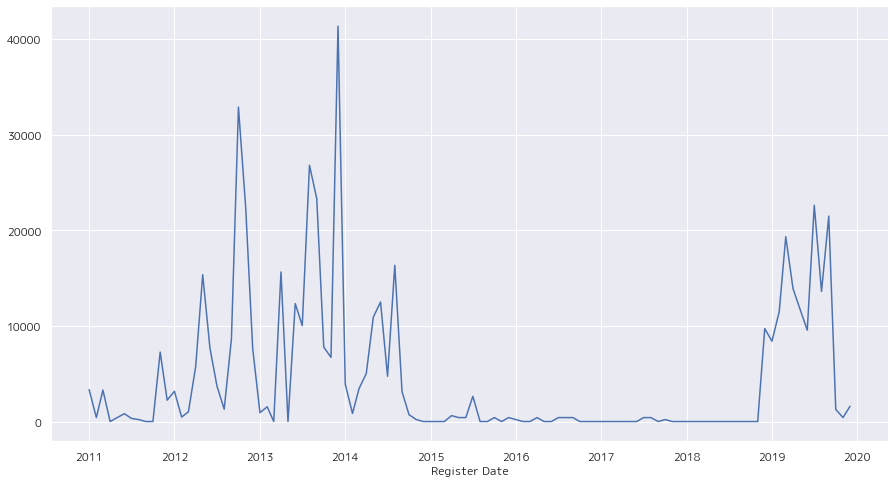

In [66]:
plt.figure(figsize=(15,8))
values = em_series.values
# plot dataset
sns.lineplot(data=em_series.resample('MS').sum())

In [38]:
em_series_month.index

DatetimeIndex(['2011-01-01', '2011-02-01', '2011-03-01', '2011-05-01',
               '2011-06-01', '2011-07-01', '2011-08-01', '2011-11-01',
               '2011-12-01', '2012-01-01', '2012-02-01', '2012-03-01',
               '2012-04-01', '2012-05-01', '2012-06-01', '2012-07-01',
               '2012-08-01', '2012-09-01', '2012-10-01', '2012-11-01',
               '2012-12-01', '2013-01-01', '2013-02-01', '2013-04-01',
               '2013-06-01', '2013-07-01', '2013-08-01', '2013-09-01',
               '2013-10-01', '2013-11-01', '2013-12-01', '2014-01-01',
               '2014-02-01', '2014-03-01', '2014-04-01', '2014-05-01',
               '2014-06-01', '2014-07-01', '2014-08-01', '2014-09-01',
               '2014-10-01', '2014-11-01', '2015-04-01', '2015-05-01',
               '2015-06-01', '2015-07-01', '2015-10-01', '2015-12-01',
               '2016-01-01', '2016-04-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2017-07-01', '2017-08-01', '2017-10-01',
      

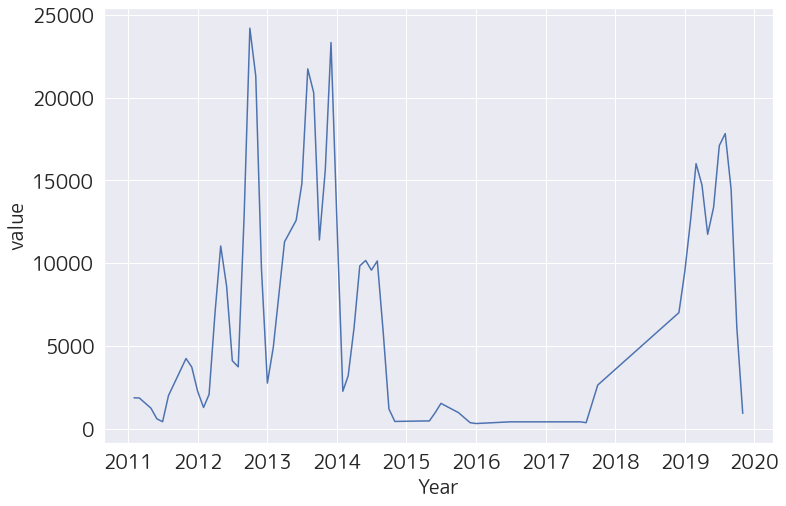

In [39]:
decomposition = seasonal_decompose(em_series_month, model='additive',period = 2)
plt.figure(figsize=(12,8))
plt.xticks(fontsize = 20, rotation = 0)
plt.yticks(fontsize = 20, rotation = 0)
plt.xlabel('Year',fontsize = 20)
plt.ylabel('value',fontsize = 20)
plt.plot(decomposition.trend)

In [40]:
def series_to_supervised(data, n_in=4, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = pd.concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

In [39]:
names = ["Gradient_Boosting", "Decision_Tree", "Extra_Trees", "Random_Forest","LGBM","XGBoost"]
models = [
    GradientBoostingRegressor(),
    DecisionTreeRegressor(max_depth=5),
    ExtraTreesRegressor(),
    RandomForestRegressor(),
    LGBMRegressor(),
    XGBRegressor()]

In [40]:
# values = pd.DataFrame(em_series.values)
# dataframe = pd.concat([values.shift(1), values], axis=1)
# dataframe.columns = ['t-1', 't']
# dataframe.dropna(inplace= True)
# target = dataframe.iloc[:,1]
# data = dataframe.iloc[:,:-1]
dataset = series_to_supervised(np.expand_dims(em_series_sample.values,axis=1), n_in=3)
data  = dataset[:,:-1]
target = dataset[:,-1]

In [41]:
# split into train and test sets
size = int(len(em_series_sample) * 0.7)
train_X, test_X = data[0:size], data[size:len(em_series_sample)]
train_y, test_y = target[0:size], target[size:len(em_series_sample)]
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
# model = XGBRegressor()
# model = LGBMRegressor()
model.fit(train_X, train_y)
yhat = model.predict(test_X)
rmse = mean_squared_error(test_y, yhat,squared=False)
mape = mean_absolute_percentage_error(test_y, yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)

Test RMSE: 951.832
Test MAPE: 1.214


In [42]:
rmse = []
mape = []
r_squared = []
for  model in models:
    model.fit(train_X, train_y)
    y_pred  = model.predict(test_X)
#     print(y_pred)
    rmse_score = mean_squared_error(test_y, y_pred,squared=False)
    mape_score = np.mean(np.abs((test_y - y_pred)/test_y)*100)
    r_squared_score  = model.score(test_X,test_y)
    r_squared.append(r_squared_score)
    rmse.append(rmse_score)
    mape.append(mape_score)

In [43]:
df_score = pd.DataFrame()
df_score['MODELS'] = names
df_score['R_SQUARED'] = r_squared
df_score['RMSE'] = rmse
df_score['MAPE'] = mape
df_score['RMSE'] = round(df_score['RMSE'],3)
df_score['MAPE'] = round(df_score['MAPE'],3)
df_score['R_SQUARED'] = round(df_score['R_SQUARED'],3)

df_score

,MODELS,R_SQUARED,RMSE,MAPE
0,Gradient_Boosting,-0.462,803.202,108.474
1,Decision_Tree,-0.160,715.445,110.694
2,Extra_Trees,-0.876,909.878,123.969
3,Random_Forest,-0.801,891.538,125.734
4,LGBM,-0.442,797.714,130.429
5,XGBoost,-0.903,916.394,114.590


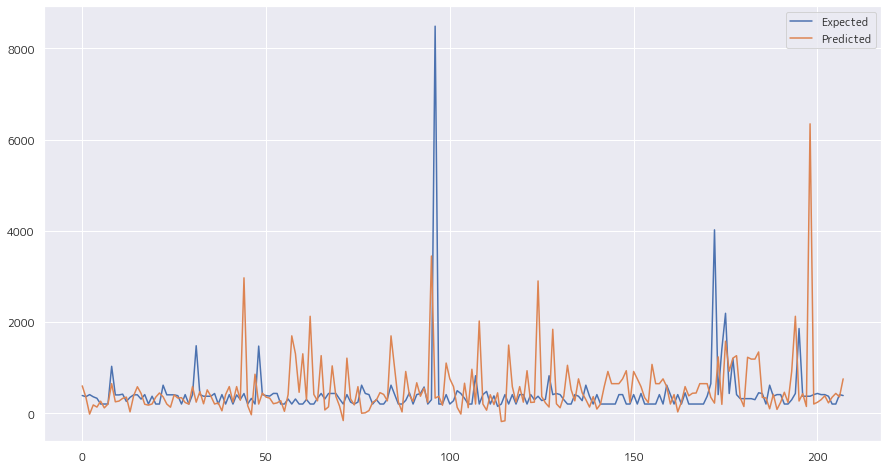

In [44]:
plt.figure(figsize=(15,8))
plt.plot(test_y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

predicted=6.201304, expected=5.331129
predicted=5.982892, expected=5.331129
predicted=5.858627, expected=6.429741
predicted=5.821379, expected=5.331129
predicted=5.640989, expected=5.331129
predicted=5.322938, expected=5.331129
predicted=5.606079, expected=7.601468
predicted=6.122861, expected=5.808413
predicted=6.056573, expected=6.717423
predicted=5.781431, expected=5.331129
predicted=6.201072, expected=8.272571
predicted=6.576606, expected=5.331129
predicted=6.681238, expected=7.457511
predicted=6.093192, expected=6.024276
predicted=6.932369, expected=8.203469
predicted=6.617188, expected=5.331129
predicted=6.918119, expected=5.331129
predicted=5.781599, expected=5.331129
predicted=6.475968, expected=5.926979
predicted=5.995048, expected=6.024276
predicted=5.968591, expected=5.331129
predicted=5.475039, expected=9.054388
predicted=6.432896, expected=5.331129
predicted=6.490880, expected=6.024276
predicted=5.614775, expected=5.331129
predicted=6.586073, expected=6.863460
predicted=6.

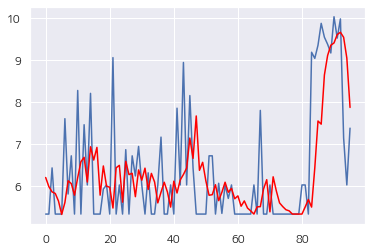

In [45]:
from statsmodels.tsa.arima.model import ARIMA

X = np.log(em_series).values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
# rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
# mape = mean_absolute_percentage_error(y_truth, y_forecasted)
rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


RMSE: 7516.445
MAPE: 3.038


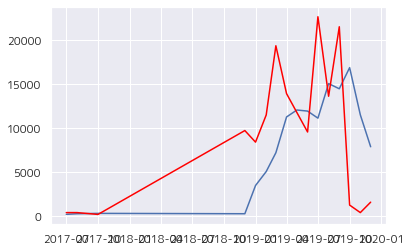

In [46]:
X = em_series.values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
# predictions = list()
# # walk-forward validation
# for t in range(len(test)):
# 	model = ARIMA(history, order=(5,1,1))
# 	model_fit = model.fit()
# 	output = model_fit.forecast()
# 	yhat = output[0]
# 	predictions.append(yhat)
# 	obs = test[t]
# 	history.append(obs)
# 	print('predicted=%f, expected=%f' % (yhat, obs))
# # evaluate forecasts
# warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
#                         FutureWarning)
# rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
# mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
# print('RMSE: %.3f' % rmse)
# print('MAPE: %.3f' % mape)
model = ARIMA(em_series, order=(1,1,1))
results = model.fit()
pred = results.predict(start='2017-01', dynamic=False)
y_forecasted = pred
y_truth = em_series['2017-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)
# plot forecasts against actual outcomes
plt.plot(y_forecasted)
plt.plot(y_truth, color='red')
plt.show()

<ipython-input-47-ba1bbbfd531d>:6: RuntimeWarning: overflow encountered in exp
  plt.plot(np.exp(test))


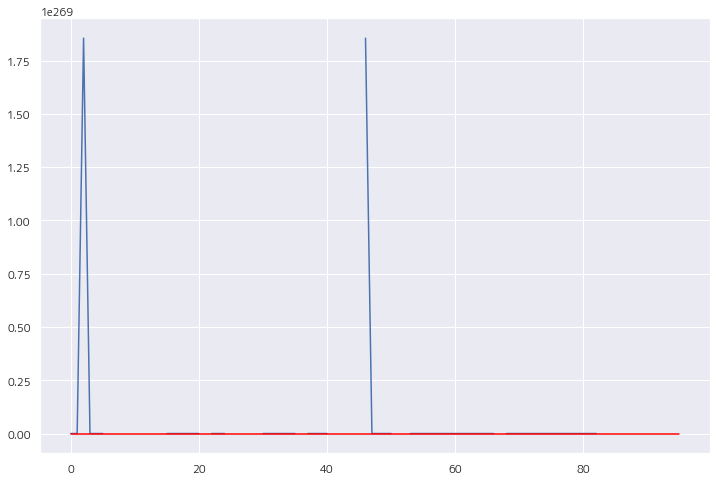

In [47]:
plt.figure(figsize=(12,8))
# plt.plot(np.exp(predictions), color='red')
# plt.xticks(rotation = 90)
# sns.lineplot(x=list(df_sum_month['month_year'][size:len(X)]),y=np.exp(test),data=np.exp(test))
# plt.legend(loc='upper left', labels=['forecast','test'])
plt.plot(np.exp(test))
plt.plot(np.exp(predictions), color='red')
plt.show()

In [49]:
X = np.log(em_series_sample).values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
# history = [x for x in train]
# predictions = list()
# # walk-forward validation
# for t in range(len(test)):
# 	model = ARIMA(history, order=(5,1,0))
# 	model_fit = model.fit()
# 	output = model_fit.forecast()
# 	yhat = output[0]
# 	predictions.append(yhat)
# 	obs = test[t]
# 	history.append(obs)
# 	print('predicted=%f, expected=%f' % (yhat, obs))
# # evaluate forecasts
# warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA')
# rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
# mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
# print('RMSE: %.3f' % rmse)
# print('MAPE: %.3f' % mape)
model = ARIMA(em_series_sample, order=(4,1,1))
results = model.fit()
pred = results.predict(start='2017-01-01', dynamic=False)
y_forecasted = pred
y_truth = em_series['2017-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)
# plot forecasts against actual outcomes
plt.plot(y_forecasted)
plt.plot(y_truth, color='red')
plt.show()

# plot forecasts against actual outcomes
# plt.plot(test)
# plt.plot(predictions, color='red')
# plt.show()

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g.

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

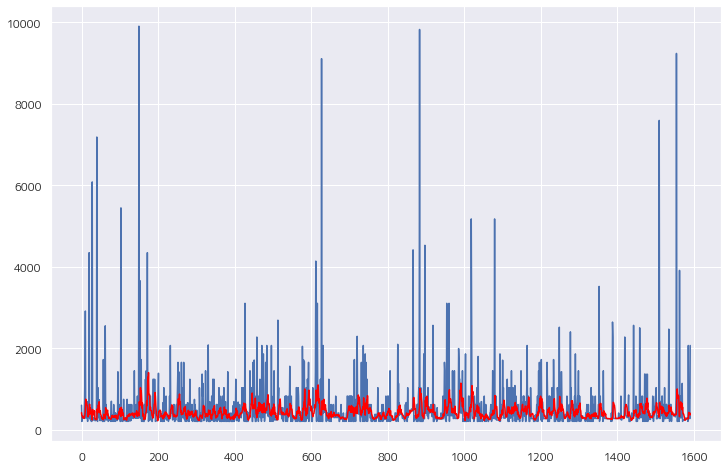

In [488]:
plt.figure(figsize=(12,8))
plt.plot(np.exp(test))
plt.plot(np.exp(predictions), color='red')
plt.show()

ValueError: arrays must all be same length

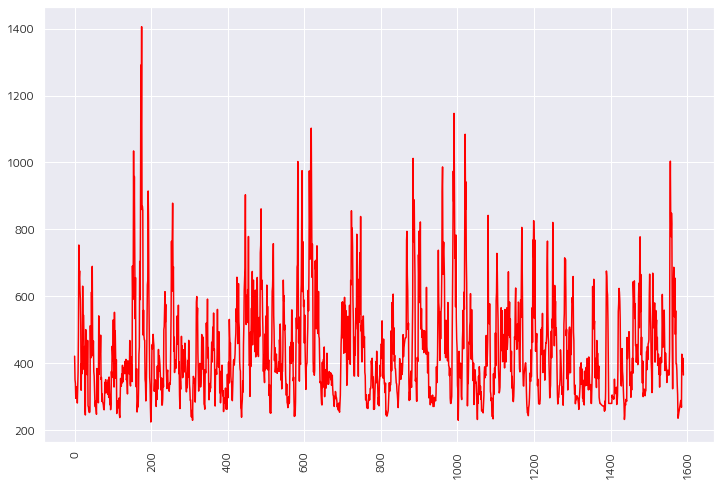

In [462]:
plt.figure(figsize=(12,8))
plt.plot(np.exp(predictions), color='red')
plt.xticks(rotation = 90)
sns.lineplot(x=list(df_sum_day['Register Date'][size:len(X)]),y=np.exp(test),data=np.exp(test))
plt.legend(loc='upper left', labels=['forecast','test'])

In [118]:
X = np.log(em_series_month).values
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# model = ARIMA(np.log(em_series_month), order=(5,1,0))
# results = model.fit()
# pred = results.predict(start='2017-01', dynamic=False)
# y_forecasted = np.exp(pred)
# y_truth = em_series_month['2017-01-01':]
# rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
# mape = mean_absolute_percentage_error(y_truth, y_forecasted)
# print('RMSE: %.3f' % rmse)
# print('MAPE: %.3f' % mape)
# # plot forecasts against actual outcomes
# plt.xticks(rotation = 90)
# plt.plot(y_forecasted,color='red')
# plt.plot(em_series_month)
# plt.show()
#walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,0,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))
# evaluate forecasts
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)
rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

predicted=580.457569, expected=413.342143
predicted=534.430234, expected=413.342143
predicted=461.842574, expected=413.342143
predicted=539.856531, expected=413.342143
predicted=532.932631, expected=206.671071
predicted=353.175064, expected=9718.770357
predicted=2776.026804, expected=8404.991429
predicted=3237.297596, expected=11489.383214
predicted=3282.354023, expected=19337.661071
predicted=5003.399426, expected=13908.298929
predicted=8880.961968, expected=11760.931429
predicted=7790.474802, expected=9556.197143
predicted=7371.261452, expected=22628.596071
predicted=13698.832007, expected=13611.772500
predicted=10028.803182, expected=21492.291429
predicted=12459.584626, expected=1265.074286
predicted=2379.511877, expected=413.342143
predicted=1038.203733, expected=1596.784286
RMSE: 7563.973
MAPE: 1.229


In [119]:
# plt.xticks(rotation = 90)
# plt.plot_date(df_sum_month['month_year'][size:len(X)], np.exp(predictions))
# list_time_test = list(df_sum_month['month_year'][size:len(X)])
# list_time_test

df_sum_month.reset_index(inplace=True)
df_sum_month['month_year'] = df_sum_month['month_year'].astype(str)
list_datetime = list(df_sum_month['month_year'][size:len(X)])
# # list_datetime = list(df_sum_month.reset_index()['month_year'][size:len(X)])
list_datetime
# df_sum_month[df_sum_month['month_year'].map(lambda x: '2017' in x)]

['2016-08-01',
 '2016-09-01',
 '2017-07-01',
 '2017-08-01',
 '2017-10-01',
 '2018-12-01',
 '2019-01-01',
 '2019-02-01',
 '2019-03-01',
 '2019-04-01',
 '2019-05-01',
 '2019-06-01',
 '2019-07-01',
 '2019-08-01',
 '2019-09-01',
 '2019-10-01',
 '2019-11-01',
 '2019-12-01']

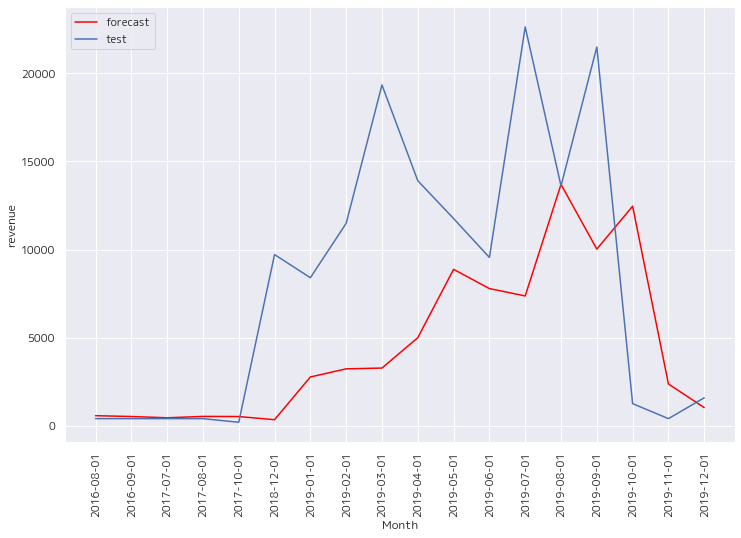

In [120]:
plt.figure(figsize=(12,8))
plt.plot(np.exp(predictions), color='red')
plt.xticks(rotation = 90)
plt.xlabel('Month')
plt.ylabel('revenue')
sns.lineplot(x=list_datetime,y='total_price',data=df_sum_month[size:len(X)])
plt.legend(loc='upper left', labels=['forecast','test'])

# plt.figure(figsize=(12,8))
# plt.plot(np.exp(predictions), color='red')
# plt.plot(em_series_month)
# plt.xticks(rotation = 90)
# plt.ylabel('revenue')
# # sns.lineplot(x=list(df_sum_year['year']),y='total_price_1g',data=df_sum_year)
# plt.legend(loc='best', labels=['forecast','test'])

In [54]:
X = em_series_month.values
size = int(len(X) * 0.5)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# model = ARIMA(np.log(em_series_month), order=(5,1,0))
# results = model.fit()
# pred = results.predict(start='2017-01', dynamic=False)
# y_forecasted = np.exp(pred)
# y_truth = em_series_month['2017-01-01':]
# rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
# mape = mean_absolute_percentage_error(y_truth, y_forecasted)
# print('RMSE: %.3f' % rmse)
# print('MAPE: %.3f' % mape)
# # plot forecasts against actual outcomes
# plt.xticks(rotation = 90)
# plt.plot(y_forecasted,color='red')
# plt.plot(em_series_month)
# plt.show()
#walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,1))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)
rmse = mean_squared_error(test, predictions,squared=False)
mape =np.mean(np.abs((test - predictions) / test)) * 100
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

predicted=23620.010721, expected=5020.946071
predicted=11180.243573, expected=10916.478571
predicted=13437.615175, expected=12504.723929
predicted=10650.923623, expected=4735.526071
predicted=6283.947440, expected=16344.198214
predicted=12837.310694, expected=3120.302857
predicted=5380.026731, expected=713.342143
predicted=7879.156823, expected=206.671071
predicted=7140.851204, expected=620.013214
predicted=5479.053625, expected=413.342143
predicted=4528.293786, expected=413.342143
predicted=2953.004166, expected=2642.251071
predicted=2793.860867, expected=413.342143
predicted=987.231108, expected=413.342143
predicted=1271.445051, expected=206.671071
predicted=906.115362, expected=413.342143
predicted=828.938905, expected=413.342143
predicted=775.132720, expected=413.342143
predicted=611.561697, expected=413.342143
predicted=520.388948, expected=413.342143
predicted=458.357955, expected=413.342143
predicted=439.100372, expected=206.671071
predicted=348.761415, expected=9718.770357
pred

RMSE: 71753.005
MAPE: 10.590


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


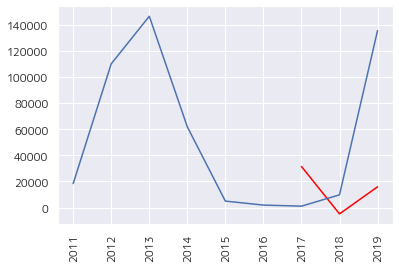

In [56]:
# X = np.log(em_series_year).values
X = em_series_year.values
# size = int(len(X) * 0.5)
# train, test = X[0:size], X[size:len(X)]
# history = [x for x in train]
model = ARIMA(em_series_year, order=(3,1,0))
results = model.fit()
pred = results.predict(start='2017-01-01', dynamic=False)
y_forecasted = pred
y_truth = em_series_year['2017-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)
# plot forecasts against actual outcomes
plt.xticks(rotation = 90)
plt.plot(y_forecasted,color='red')
plt.plot(em_series_year)
plt.show()
# predictions = list()|
# # walk-forward validation
# for t in range(len(test)):
# 	model = ARIMA(history, order=(1,1,0))
# 	model_fit = model.fit()
# 	output = model_fit.forecast()
# 	yhat = output[0]
# 	predictions.append(yhat)
# 	obs = test[t]
# 	history.append(obs)
# 	print('predicted=%f, expected=%f' % (yhat, obs))
# # evaluate forecasts
# rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
# mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
# print('RMSE: %.3f' % rmse)
# print('MAPE: %.3f' % mape)
# # plot forecasts against actual outcomes
# plt.plot(test)
# plt.plot(predictions, color='red')
# plt.show()

In [57]:
# df_sum_year.reset_index(inplace=True)
# df_sum_year['year'] = df_sum_year['year'].astype(str)
list_datetime = list(df_sum_year['year'][size:len(X)])
# # list_datetime = list(df_sum_month.reset_index()['month_year'][size:len(X)])
# list_datetime
list(df_sum_year['year'][6:])

[Timestamp('2017-01-01 00:00:00'),
 Timestamp('2018-01-01 00:00:00'),
 Timestamp('2019-01-01 00:00:00')]

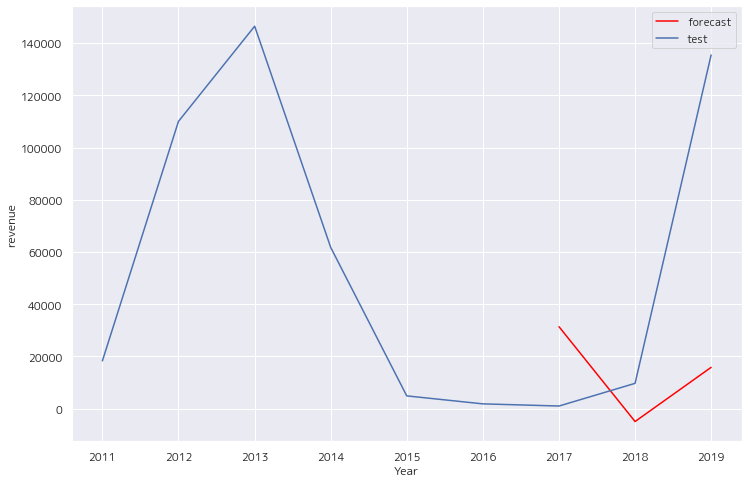

In [58]:
plt.figure(figsize=(12,8))
plt.plot(y_forecasted, color='red')
plt.plot(em_series_year)
# plt.xticks(rotation = 90)
plt.xlabel('Year')
plt.ylabel('revenue')
# sns.lineplot(x=list(df_sum_year['year']),y='total_price_1g',data=df_sum_year)
plt.legend(loc='best', labels=['forecast','test'])

In [64]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [65]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
            mod = SARIMAX(em_series_month,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1463.6826159443951
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1204.5665866040997
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1214.4718158668404
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:942.7019066092066
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1225.770062887054
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1209.013168612887
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:974.394368553723
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:942.170277539414
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1422.2024411190644
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1168.8233582244577
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1182.3281422350267
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:918.6641565449515
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1212.7405049395716
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1170.683285739297
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:967.9574382854047


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:918.7907098517547
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1419.3461621471213
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1170.503630246791
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:1191.6896716163335
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:927.0471101077379
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:1193.3076606905843


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1172.1886584500191
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:953.9944086362788
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:918.7911064886256
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:1383.9631372137599
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:1137.226785642893
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:1158.3844155588304
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:889.786726145087
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:1181.3621424351122


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:1137.6310400607867
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:943.5192294035334
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:888.1284273528518
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:1428.4249184268658
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1181.6400167191728
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:1199.7540495509597
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:933.9077695127295


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:1183.2740775067994
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1183.4074195233843
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:943.1847751073108
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:932.3341419509717
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:1404.6334589951614


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:1157.1584490148946
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:1177.3693043491419
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:910.890155167245
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:1181.388311367782
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:1158.2618626445337


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:942.320386283855
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:909.438673753262
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:1415.3391395325814
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1165.9266764084628
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:1186.78529146844
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:917.4563134126075


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:1167.9343548425688
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1167.42877972477
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:927.1978734822403
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:914.0851721731258


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:1382.1039150977754
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:1137.7831157952608
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:1159.4125764819387
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:891.2825474025117
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:1159.5711727414007


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequenc

ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:1137.4494653853137
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:924.0044350602751
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:889.4245395460883


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [114]:
mod =SARIMAX(em_series_month,
                                order=(5, 0, 0),
                                seasonal_order=(0, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4200      0.159      2.648      0.008       0.109       0.731
ar.L2          0.0629      0.125      0.504      0.615      -0.182       0.308
ar.L3          0.0596      0.205      0.290      0.772      -0.343       0.462
ar.L4         -0.1790      0.175     -1.020      0.308      -0.523       0.165
ar.L5          0.3473      0.144      2.418      0.016       0.066       0.629
sigma2      6.282e+07   1.84e-09   3.41e+16      0.000    6.28e+07    6.28e+07


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


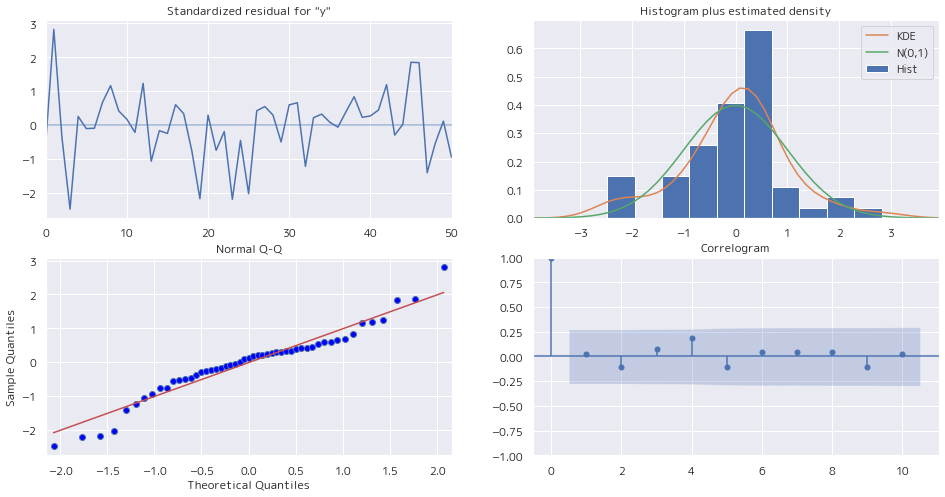

In [115]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

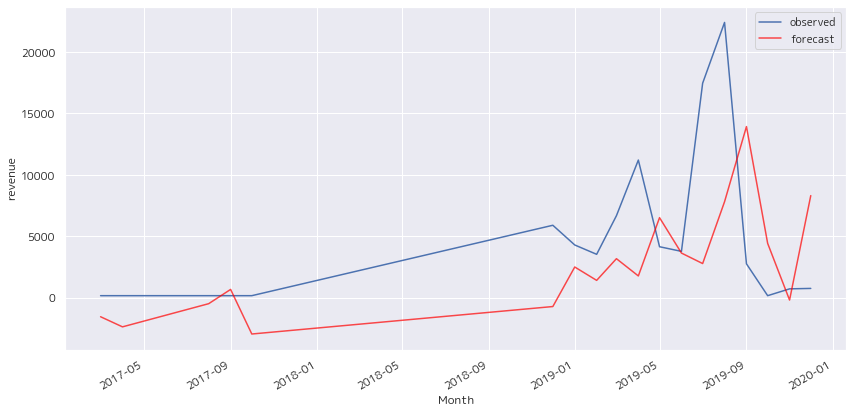

In [122]:
pred = results.get_prediction(start='2017-01', dynamic=False)
pred_ci = pred.conf_int()

ax = em_series_month['2017-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='forecast', color='red', alpha=.7, figsize=(14, 7))

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Month')
ax.set_ylabel('revenue')
plt.legend()

plt.show()

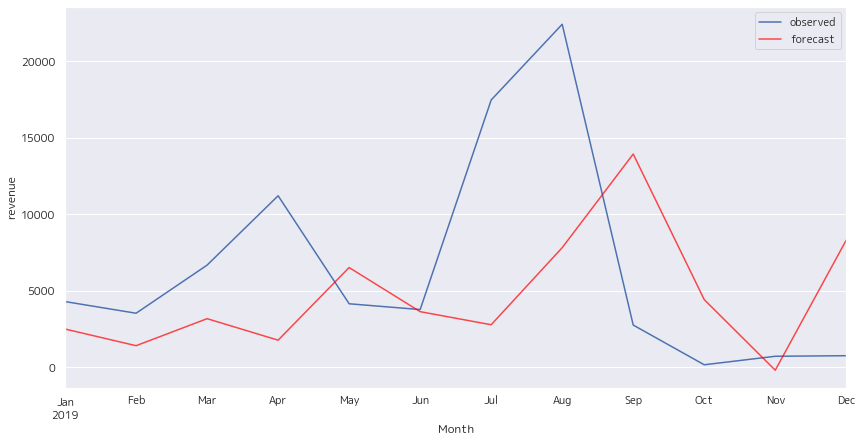

In [117]:
pred = results.get_prediction(start='2019-01', dynamic=False)
pred_ci = pred.conf_int()

ax = em_series_month['2019-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='forecast', color='red', alpha=.7, figsize=(14, 7))

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Month')
ax.set_ylabel('revenue')
plt.legend()

plt.show()

In [123]:
y_forecasted = pred.predicted_mean
y_truth = em_series_month['2017-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted,)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

RMSE: 6695.977
MAPE: 5.637


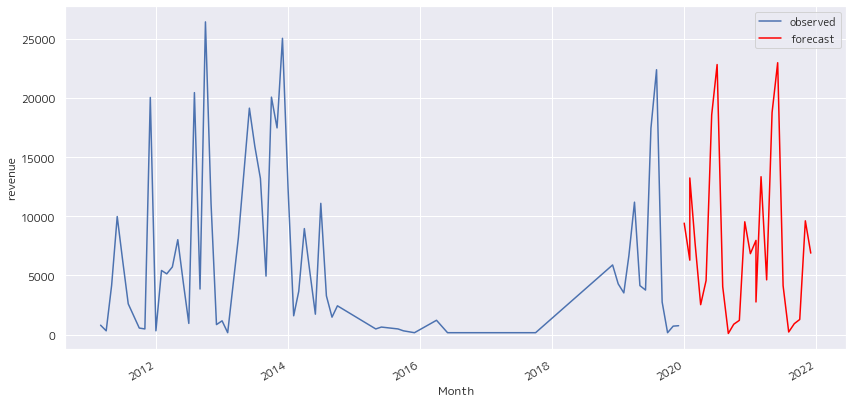

In [124]:
index = pd.to_datetime(['2020-01-01', '2020-02-01','2020-03-01','2020-02-01','2020-04-01','2020-05-01',
                        '2020-06-01','2020-07-01','2020-08-01','2020-09-01','2020-10-01','2020-11-01','2020-12-01',
                       '2021-01-01', '2021-02-01','2021-03-01','2021-02-01','2021-04-01','2021-05-01',
                        '2021-06-01','2021-07-01','2021-08-01','2021-09-01','2021-10-01','2021-11-01','2021-12-01'])
pred_uc = results.get_forecast(steps=len(index),index=index)
pred_ci = pred_uc.conf_int()
ax = em_series_month.plot(label='observed', figsize=(14, 7),)
pred_uc.predicted_mean.plot(ax=ax, label='forecast',color='red')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Month')
ax.set_ylabel('revenue')
plt.legend()
plt.show()

In [120]:
pred_uc.predicted_mean.to_frame()

,predicted_mean
2020-01-01,9421.608076
2020-02-01,6291.744497
2020-03-01,7747.700706
2020-02-01,13241.875238
2020-04-01,2529.643178
2020-05-01,4569.875117
2020-06-01,18577.284394
2020-07-01,22831.502207
2020-08-01,4052.400029
2020-09-01,95.924209


In [125]:
mod =SARIMAX(em_series_year,
                                order=(0, 1, 0),
                                seasonal_order=(0, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2          1e-10          0        inf      0.000       1e-10       1e-10


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tools\eval_measures.py:406: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + np.log(nobs) * df_modelwc
D:\Software\Anaconda\lib\site-packages\statsmodels\tools\eval_measures.py:431: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + 2 * np.log(np.log(nobs)) * df_modelwc
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:2937: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse
D:\Software\Anaconda

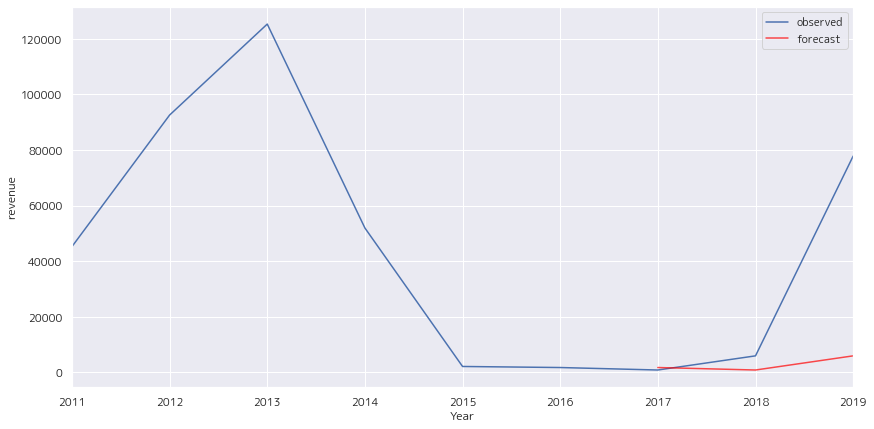

In [126]:
pred = results.get_prediction(start='2017-01-01', dynamic=False)
pred_ci = pred.conf_int()

ax = em_series_year['2011-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='forecast', alpha=.7, figsize=(14, 7),color='red')

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Year')
ax.set_ylabel('revenue')
plt.legend()

plt.show()

In [127]:
y_forecasted = pred.predicted_mean
y_truth = em_series_year['2017-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted,)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

RMSE: 41625.728
MAPE: 0.970


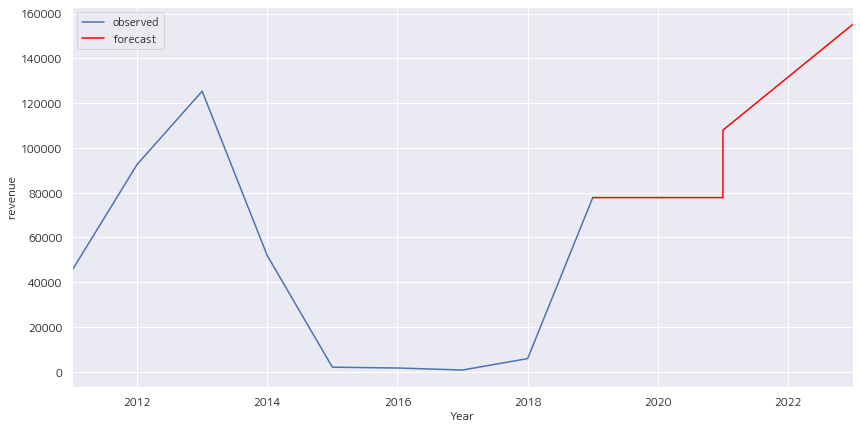

In [128]:
index = pd.to_datetime(['2019', '2020','2021','2021','2023'])
pred_uc = results.get_forecast(steps=len(index),index=index)
pred_ci = pred_uc.conf_int()
ax = em_series_year.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='forecast',color='red')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('revenue')
plt.legend()
plt.show()

In [129]:
pred_uc.predicted_mean.to_frame()

,predicted_mean
2019-01-01,77800.7575
2020-01-01,77800.7575
2021-01-01,77800.7575
2021-01-01,107937.3675
2023-01-01,155298.7450


In [41]:
df_1nz  = df_copy[df_copy["extracted_engine"].apply(lambda x : 'B3' in x)]
df_1nz

,index,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,...,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD,extracted_engine,brand,month_year,year,len_unique_em,len_em
20914,995,2011-01-21,8407343009,ДВИГАТЕЛИ БЕНЗ.БЫВ.В УП.В СБОРЕ С НАВЕСНЫМ ОБО...,"TOYOTA,HONDA,NISSAN,MMC,MAZDA,SUBARU,SUZUKI","TOYOTA,HONDA,NISSAN,MMC,MAZDA,SUBARU,SUZUKI",ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan","TATSUMI SHOKAI CO.,LTD,3-8-7,IIDABASHI,CHIYODA...",...,CFR,14030.0,14030.0,7625.00,[B3],MAZDA,2011-01,2011,1,1
20916,1485,2011-02-04,8407343009,"ДВИГАТЕЛИ-20ШТ, БЫВШ. В УПОТР. КАРБЮР. ОБЪЕМ 1...","TOYOTA MOTOR CO.,HONDA MOTOR CO.,NISSAN MOTOR ...","TOYOTA,HONDA,NISSAN,SUZUKI,MITSUBISHI,MAZDA",ВОСТОЧНЫЙ,"JP, JPN, Japan","CT, , Taiwan",M S PLANNING CO. LTD.,...,CFR,4405.5,4405.5,5405.86,"[B3, ZL]",MAZDA,2011-02,2011,2,2
20919,1626,2011-02-09,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ Б/У ОТ А/М В СБОРЕ С АКП:...,MAZDA,MAZDA,ВЛАДИВОСТОК,"JP, JPN, Japan","CT, , Taiwan",TOYAMA KAIGAI BOEKI CO.LTD.,...,CFR,346.5,346.5,99.00,[B3],MAZDA,2011-02,2011,1,1
20928,1963,2011-02-17,8407343009,ДВИГAТEЛИ БEНЗ БЫВ В УП В CБOPE C НAВECНЫМ OБO...,"HONDA MOTOR CO.,LTD,MAZDA MOTOR CORPORATION,TO...","HONDA,MAZDA,TOYOTA,NISSAN",ВОСТОЧНЫЙ,"JP, JPN, Japan","CT, , Taiwan","DAISHA CO.,LTD",...,CFR,4500.0,4500.0,4126.38,[B3],MAZDA,2011-02,2011,1,1
20935,2671,2011-02-24,8407343009,ДВИГАТЕЛИ БЕНЗ.БЫВ.В УП.В СБОРЕ С НАВЕСНЫМ ОБО...,"TOYOTA MOTOR CORPORATION,HONDA MOTOR CO.LTD, N...","TOYOTA,HONDA,NISSAN,MAZDA",ВОСТОЧНЫЙ,"JP, JPN, Japan","CT, , Taiwan","BAN CO.,LTD",...,CFR,4985.0,4985.0,4569.18,"[B3, FP]",MAZDA,2011-02,2011,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24076,245535,2019-10-01,8407343009,"ДВС БЕНЗИН-2ШТ. С КОРОБКАМИ ПЕРЕДАЧ, С НАВЕСНЫ...",MAZDA MOTOR CORPORATION,MAZDA,ВОСТОЧНЫЙ,"JP, JPN, Japan",JAPAN,TAMURA SANGYO CO.LTD,...,CFR,470.0,470.0,720.00,"[ZJ, B3]",MAZDA,2019-10,2019,2,2
24091,248618,2019-10-01,8407343009,ДВИГАТЕЛИ С ВОЗВРАТНО-ПОСТУПАТЕЛЬНЫМ ДВИЖЕНИЕМ...,MAZDA MOTOR CORP.,MAZDA,ВЛАДИВОСТОК,"JP, JPN, Japan",JAPAN,BEYOND TRADING LIMITED,...,CFR,218.0,218.0,329.18,[B3],MAZDA,2019-10,2019,1,1
24092,248621,2019-10-01,8407343009,ДВИГАТЕЛИ ВНУТРЕННЕГО СГОРАНИЯ БЫВШИЕ В УПОТРЕ...,HONDA MOTOR CORPORATIONNISSAN MOTOR CO.LTDTOYO...,HONDANISSANTOYOTAMAZDA,ВОСТОЧНЫЙ,"JP, JPN, Japan",JAPAN,EAST-JAPAN RECYCLING RESOURCES CO.LTD (EARC),...,CFR,13092.0,13092.0,20911.86,"[FS, B3, B3, LF, LF]",MAZDA,2019-10,2019,3,5
24109,254397,2019-12-01,8407343009,"ДВС БЕНЗИН-4ШТ. С КОРОБКАМИ ПЕРЕДАЧ, С НАВЕСНЫ...",MAZDA MOTOR CORPORATION,MAZDA,ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan",SHOWA METAL CO.LTD,...,CFR,870.0,870.0,1331.75,"[B3, FP, FP, FP]",MAZDA,2019-12,2019,2,4


In [42]:
df_1nz['count_em']  = df_1nz['extracted_engine'].map(lambda x: count_length(x,'B3'))
unit_price_1nz = df_1nz[(df_1nz.Quantity == 1) & (df_1nz.count_em==1)].describe().loc[('mean','Cargo Value USD')]
df_1nz['Quantity'] = df_1nz.apply(lambda x : normalize_zero (x,unit_price_1nz), axis=1)
df_1nz['total_price'] = df_1nz.apply(lambda x : check_count_em(x,unit_price_1nz),axis=1)

<ipython-input-42-3996a646e7ef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1nz['count_em']  = df_1nz['extracted_engine'].map(lambda x: count_length(x,'B3'))
<ipython-input-42-3996a646e7ef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1nz['Quantity'] = df_1nz.apply(lambda x : normalize_zero (x,unit_price_1nz), axis=1)
<ipython-input-42-3996a646e7ef>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [43]:
df_1g  = df_copy[df_copy["extracted_engine"].apply(lambda x : 'FS' in x)]
df_1g

,index,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,...,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD,extracted_engine,brand,month_year,year,len_unique_em,len_em
20950,2890,2011-03-14,8407343009,ДВИГАТЕЛИ ВНУТРЕННЕГО СГОРАНИЯ БЫВШИЕ В УПОТРЕ...,"HONDA MOTOR CO.,LTD,MITSUBISHI MOTORS CORPORAT...","HONDA,MITSUBISHI,MAZDA,SUBARU",CFR ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan",HEIWA SYOUJI KABUSHIKIGAISHA 10-8 MINAMIFUTAJI...,...,CFR,7068.6,7068.6,6962.42,"[GY, FS, B3, ZL, ZL, Z5]",MAZDA,2011-03,2011,5,6
20952,3017,2011-03-01,8407343009,ДВИГАТЕЛЬ БЕНЗИНОВЫЙ Б/У ОТ А/М В СБОРЕ С АКП:...,MAZDA,MAZDA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",DAIKOKUTEN CO LTD,...,CFR,707.0,707.0,202.00,"[FS, ZL]",MAZDA,2011-03,2011,2,2
20953,3065,2011-03-01,8407343009,ДВИГ.БЕНЗ.ДЛЯ А/М МАСС.МЕНЕЕ 3.5 Т. С К/П БЫВШ...,"TOYOTA MOTOR CORPORATION СМ.ДОПОЛНЕНИЕ, TOYOTA...","TOYOTA,HONDA,NISSAN,MAZDA,MITSUBISHI,SUBARU",CFR ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan",HIRANUMASHOKAI,...,unknown,9360.0,9360.0,4680.00,"[FS, FP]",MAZDA,2011-03,2011,2,2
20954,3070,2011-03-03,8407343009,ДВИГАТЕЛИ КАРБ.БЫВШ.В УП.В СБОРЕ С НАВЕСНЫМ ОБ...,"TOYOTA MOTOR CORPORATION,NISSAN MOTOR CO.,LTD,...","TOYOTA,NISSAN,HONDA,SUBARU,MAZDA",ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan","O.M.AUTO.,LTD NISHIKI-MATI 5-1 MINATO-KU NAGOY...",...,CFR,5110.6,5110.6,3416.36,"[B5, ZJ, FS, ZL]",MAZDA,2011-03,2011,4,4
20960,4581,2011-03-25,8407343009,ДВИГАТЕЛЬ КАРБ.БЫВШ.В УП.ДЛЯ Л/А ОБ.1300-2000С...,"TOYOTA MOTOR CORPORATION,NISSAN MOTOR CO.,LTD,...","MMC,SUBARU,HONDA,NISSAN,TOYOTA,MAZDA",ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan","ISHIDA SHOTEN CO.LTD 118,AZA-HIGAHI YOKONE,HIG...",...,CFR,6800.0,6800.0,6426.87,"[FS, E5, F8]",MAZDA,2011-03,2011,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24066,244066,2019-09-01,8407343009,"ДВИГАТЕЛЬ БЕНЗИНОВЫЙ БЫВ.В УПОТР.ДЛЯ Л/А,В СБО...",MAZDA MOTOR CO.LTD,: MAZDA РЕГИСТРАЦИОННЫЙ ПО ТРОИС № 03321/03177...,ЙОКОГАМА,JAPAN,JAPAN,SHOWA METAL CO.LTD.,...,FOB,415.0,415.0,640.54,"[FS, B3]",MAZDA,2019-09,2019,2,2
24092,248621,2019-10-01,8407343009,ДВИГАТЕЛИ ВНУТРЕННЕГО СГОРАНИЯ БЫВШИЕ В УПОТРЕ...,HONDA MOTOR CORPORATIONNISSAN MOTOR CO.LTDTOYO...,HONDANISSANTOYOTAMAZDA,ВОСТОЧНЫЙ,"JP, JPN, Japan",JAPAN,EAST-JAPAN RECYCLING RESOURCES CO.LTD (EARC),...,CFR,13092.0,13092.0,20911.86,"[FS, B3, B3, LF, LF]",MAZDA,2019-10,2019,3,5
24105,250407,2019-11-01,8407343009,"ДВИГАТЕЛЬ В СБОРЕ С АКПП И ПЕРЕДНЕЙ ПОДВЕСКОЙ,...",MAZDA,MAZDA,ВЛАДИВОСТОК,JAPAN,JAPAN,AKSYS CO. LTD.,...,CFR,370.0,370.0,555.00,[FS],MAZDA,2019-11,2019,1,1
24106,251154,2019-11-01,8407343009,ЧАСТИ И ПРИНАДЛЕЖНОСТИ А/М Б/У:ДВИГАТЕЛЬ БЕНЗИ...,MAZDA MOTOR CO. LTD,MAZDA ЯПОНИЯ,ВЛАДИВОСТОК,JAPAN,JAPAN,HASEGAWA MOTOR COMPANY LTD.,...,CFR,1260.0,1260.0,1902.60,"[B5, FS, LF, LF, L3, L3]",MAZDA,2019-11,2019,4,6


In [44]:
df_1g['count_em']  = df_1g['extracted_engine'].map(lambda x: count_length(x,'FS'))
unit_price_1g = df_1g[(df_1g.Quantity == 1) & (df_1g.count_em==1)].describe().loc[('mean','Cargo Value USD')]
df_1g['Quantity'] = df_1g.apply(lambda x : normalize_zero (x,unit_price_1g), axis=1)
df_1g['total_price'] = df_1g.apply(lambda x : check_count_em(x,unit_price_1g),axis=1)

<ipython-input-44-4541eb76403e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1g['count_em']  = df_1g['extracted_engine'].map(lambda x: count_length(x,'FS'))
<ipython-input-44-4541eb76403e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1g['Quantity'] = df_1g.apply(lambda x : normalize_zero (x,unit_price_1g), axis=1)
<ipython-input-44-4541eb76403e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [45]:
df_fp  = df_copy[df_copy["extracted_engine"].apply(lambda x : 'FP' in x)]
df_fp

,index,Register Date,HS Code,Product Description,Producer,Brand,Place of Receipt,Country of Origin,Country of Sales,Shipper,...,Incoterms,Gross Weight in KG,Net Weight in KG,Cargo Value USD,extracted_engine,brand,month_year,year,len_unique_em,len_em
20910,54,2011-01-14,8407343009,"ДВИГАТЕЛЬ БЕНЗИНОВЫЙ, БЫВШИЙ В УПОТРЕБЛЕНИИ, Д...","TOYOTA, SUZUKI, HONDA, NISSAN, MAZDA","TOYOTA, SUZUKI, HONDA, NISSAN, MAZDA",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","HIRAYASU CO.,LTD",...,CFR,7450.0,7450.0,3950.00,[FP],MAZDA,2011-01,2011,1,1
20911,55,2011-01-14,8407343009,"ДВИГАТЕЛЬ БЕНЗИНОВЫЙ, БЫВШИЙ В УПОТРЕБЛЕНИИ, Д...","TOYOTA, HONDA, MAZDA, NISSAN, MITSUBISHI","TOYOTA, HONDA, MAZDA, NISSAN, MITSUBISHI",ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan","HIKARI SYOJI CO.,LTD",...,CFR,7235.0,7235.0,3945.00,"[ZL, FP]",MAZDA,2011-01,2011,2,2
20917,1490,2011-02-04,8407343009,ДВИГ.БЕНЗ.ДЛЯ А/М МАСС.МЕНЕЕ 3.5 Т. С К/П БЫВШ...,"TOYOTA MOTOR CORPORATION СМ.ДОПОЛНЕНИЕ, TOYOTA...","TOYOTA,HONDA,NISSAN,MAZDA,MITSUBISHI,SUBARU",ВОСТОЧНЫЙ,"JP, JPN, Japan","CT, , Taiwan",HIRANUMASHOKAI,...,CFR,6210.0,6210.0,3240.00,[FP],MAZDA,2011-02,2011,1,1
20920,1670,2011-02-09,8407343009,"ДВС БЕНЗ.-6ШТ,БЫВШ.В УПОТРЕБ.ДЛЯ А/М,С НАВЕС.О...","MAZDA MOTOR CORPORATION,TOYOTA MOTOR CORPORATI...","MAZDA,TOYOTA,HONDA",ВОСТОЧНЫЙ,"JP, JPN, Japan","CT, , Taiwan","TATSUMI SHOKAI CO.,LTD.",...,CFR,1515.0,1515.0,2272.50,[FP],MAZDA,2011-02,2011,1,1
20933,2655,2011-02-28,8407343009,ДВИГAТEЛЬ БEНЗИНOВЫИ C ТPAНCМИCCИEИ A/М Б/У: M...,"MAZDA, PEUGEOT, FORD","MAZDA, PEUGEOT, FORD",ВЛАДИВОСТОК,"JP, JPN, Japan","CT, , Taiwan","CRYSTAL GROUP CO., LTD",...,DES,800.0,800.0,850.00,[FP],MAZDA,2011-02,2011,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24101,248682,2019-10-01,8407343009,"ЗАП,ЧАСТИ ДЛЯ АВТОМОБИЛЕЙ, Б/У: ДВИГАТЕЛИ БЫВШ...",MAZDA,MAZDA,ВЛАДИВОСТОК,"JP, JPN, Japan",JAPAN,SEAPARTS CO. LTD,...,CFR,210.0,210.0,317.45,[FP],MAZDA,2019-10,2019,1,1
24104,249858,2019-11-01,8407343009,ДВИГАТЕЛИ БЕНЗИНОВЫЕ БЫВШИЕ В УПОТРЕБ. СТАРШЕ ...,MAZDA MOTOR CO,MAZDA,ВОСТОЧНЫЙ,MALAYSIA,MALAYSIA,HAN SAN AUTO PARTS SDN BND,...,CFR,1797.0,1797.0,2850.00,"[ZL, ZL, ZL, ZL, ZL, FP, FP, FP, FP]",MAZDA,2019-11,2019,2,9
24109,254397,2019-12-01,8407343009,"ДВС БЕНЗИН-4ШТ. С КОРОБКАМИ ПЕРЕДАЧ, С НАВЕСНЫ...",MAZDA MOTOR CORPORATION,MAZDA,ВОСТОЧНЫЙ,"JP, JPN, Japan","JP, JPN, Japan",SHOWA METAL CO.LTD,...,CFR,870.0,870.0,1331.75,"[B3, FP, FP, FP]",MAZDA,2019-12,2019,2,4
24117,256773,2019-12-01,8407343009,ДВИГАТЕЛИ С ИСКРОВЫМ ЗАЖИГАНИЕМ С ВОЗВРАТНО-ПО...,MAZDA MOTOR CORPORATION,MAZDA,ВЛАДИВОСТОК,"JP, JPN, Japan","JP, JPN, Japan",TRADE WISE CO. LTD,...,CFR,560.0,560.0,845.60,[FP],MAZDA,2019-12,2019,1,1


In [46]:
df_fp['count_em']  = df_fp['extracted_engine'].map(lambda x: count_length(x,'FP'))
unit_price_1g = df_fp[(df_fp.Quantity == 1) & (df_fp.count_em==1)].describe().loc[('mean','Cargo Value USD')]
df_fp['Quantity'] = df_fp.apply(lambda x : normalize_zero (x,unit_price_1g), axis=1)
df_fp['total_price'] = df_fp.apply(lambda x : check_count_em(x,unit_price_1g),axis=1)

<ipython-input-46-56b8db5b2d50>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fp['count_em']  = df_fp['extracted_engine'].map(lambda x: count_length(x,'FP'))
<ipython-input-46-56b8db5b2d50>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fp['Quantity'] = df_fp.apply(lambda x : normalize_zero (x,unit_price_1g), axis=1)
<ipython-input-46-56b8db5b2d50>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [47]:
df_3s['name_em'] = 'L3'
df_1nz['name_em'] = 'B3'
df_1g['name_em'] = 'FS'
df_fp['name_em'] = 'FP'

<ipython-input-47-6d6a7b376330>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3s['name_em'] = 'L3'
<ipython-input-47-6d6a7b376330>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1nz['name_em'] = 'B3'
<ipython-input-47-6d6a7b376330>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

In [48]:
df_best_engine  = pd.concat([df_3s,df_1nz,df_1g,df_fp],axis=0)

In [49]:
df_group_year = df_best_engine.groupby(['year','name_em'])['total_price'].sum().reset_index()
df_group_year

,year,name_em,total_price
0,2011,B3,86674.429412
1,2011,FP,66094.554615
2,2011,FS,45204.915000
3,2011,L3,18311.230357
4,2012,B3,88706.938235
5,2012,FP,26450.463846
6,2012,FS,92566.292500
7,2012,L3,110007.677143
8,2013,B3,107575.825882
9,2013,FP,119931.863846


Text(0.5, 0, 'Year')

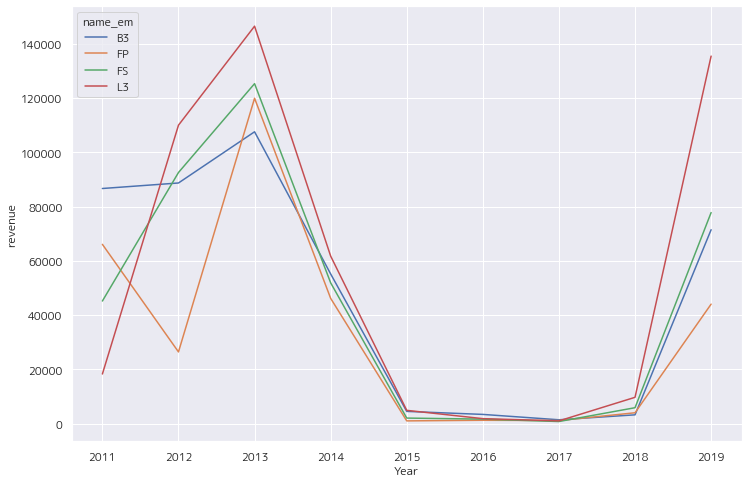

In [50]:
plt.figure(figsize=(12,8))
sns.lineplot(x='year',y='total_price',hue='name_em',data=df_group_year)
plt.ylabel('revenue')
plt.xlabel('Year')

In [51]:
df_group_month = df_best_engine.groupby(['month_year','name_em'])['total_price'].sum().reset_index()
df_group_month

,month_year,name_em,total_price
0,2011-01,B3,7625.000000
1,2011-01,FP,4064.807692
2,2011-01,L3,3339.770000
3,2011-02,B3,17600.447647
4,2011-02,FP,10792.115385
...,...,...,...
284,2019-11,L3,413.342143
285,2019-12,B3,427.761765
286,2019-12,FP,1535.023077
287,2019-12,FS,750.010000


Text(0.5, 0, 'Month')

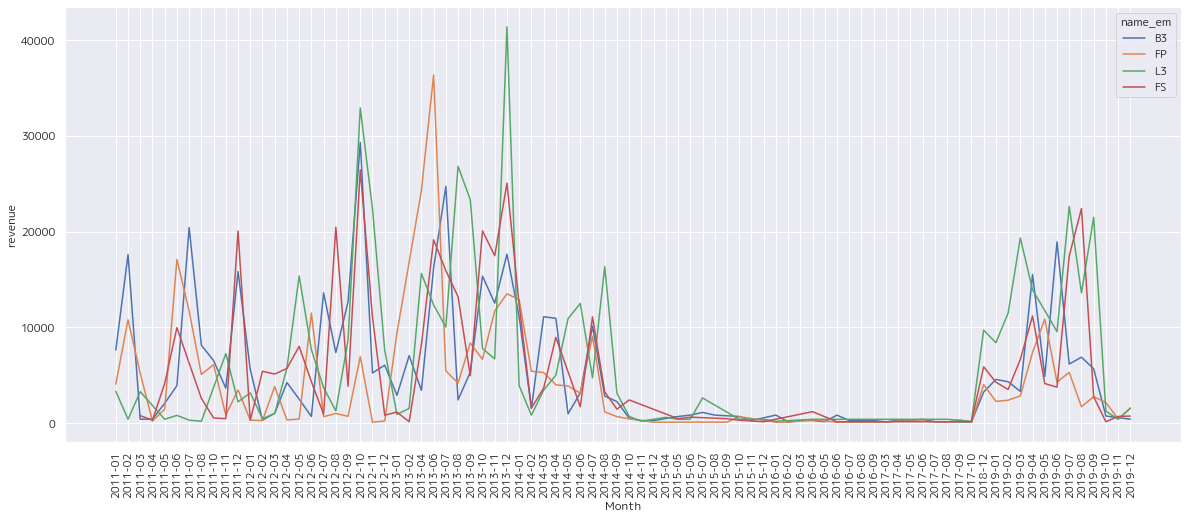

In [52]:
plt.figure(figsize=(20,8))
sns.lineplot(x='month_year',y='total_price',hue='name_em',data=df_group_month)
plt.xticks(rotation = 90)
plt.ylabel('revenue')
plt.xlabel('Month')

Text(0.5, 0, 'Month')

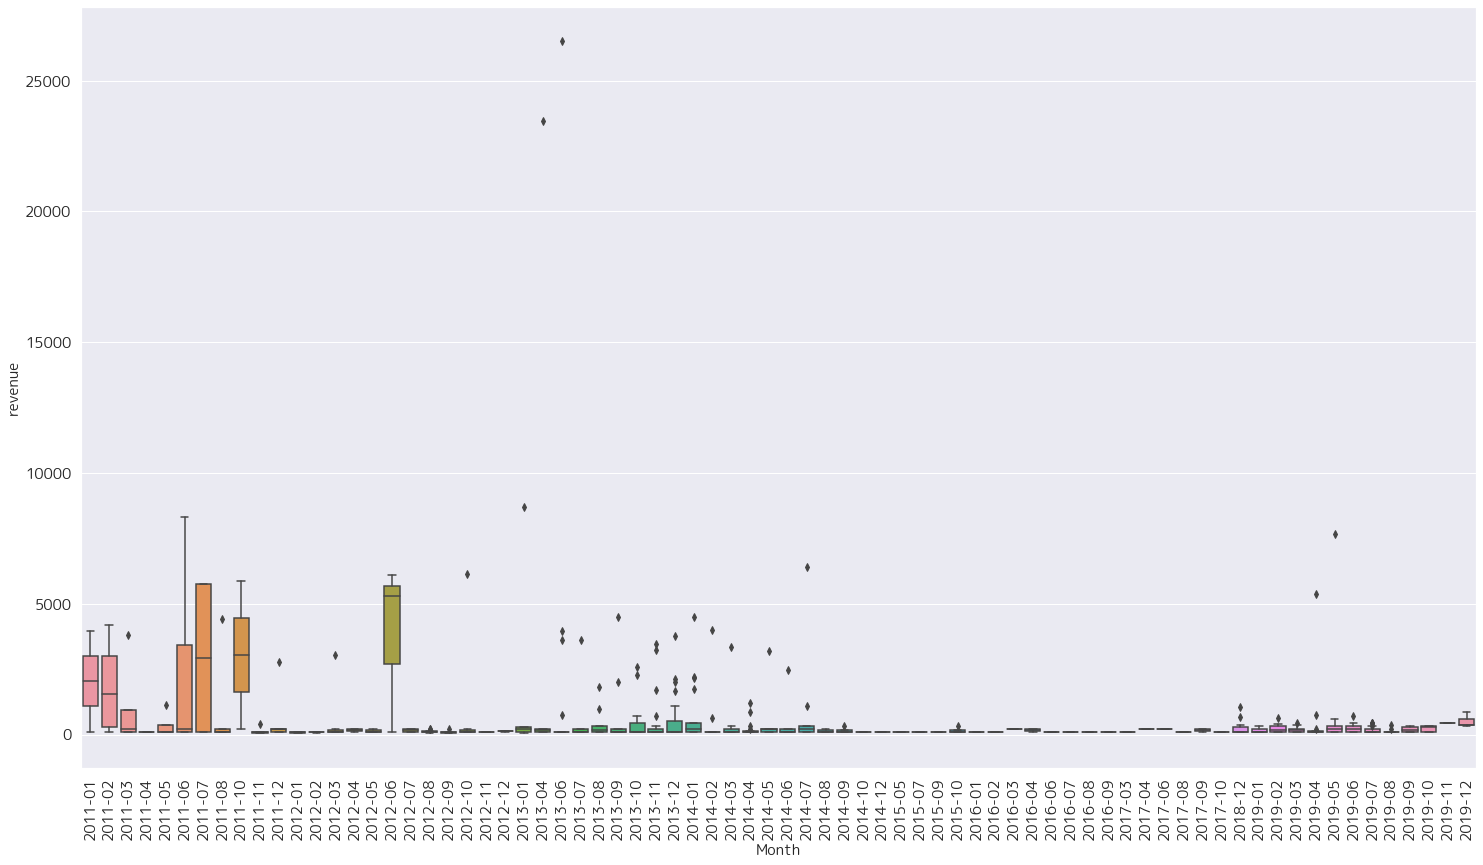

In [222]:
plt.figure(figsize=(25,14))
sns.boxplot(x='month_year',y='total_price',data=df_fp)
# plt.xticks(rotation = 90)
plt.xticks(fontsize = 15,rotation = 90, weight='bold')
plt.yticks(fontsize = 15)
plt.ylabel('revenue',fontsize = 15)
plt.xlabel('Month',fontsize = 15)

Text(0.5, 0, 'Year')

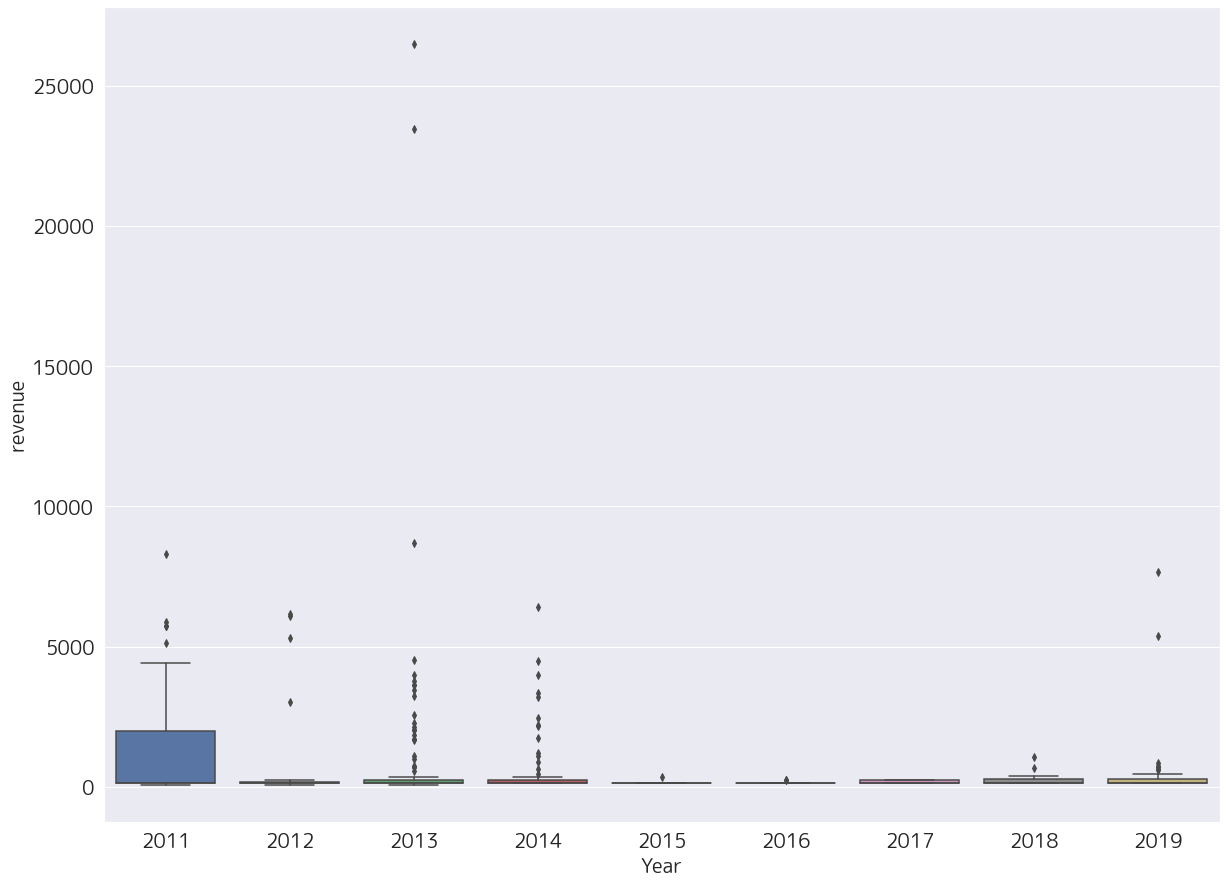

In [223]:
plt.figure(figsize=(20,15))
sns.boxplot(x='year',y='total_price',data=df_fp)
# plt.xticks(rotation = 90)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('revenue',fontsize = 20)
plt.xlabel('Year',fontsize = 20)

# Engine Model B3

In [76]:
df_sum_day = df_1nz.groupby(['Register Date'])['total_price'].sum().reset_index()
df_sum_month = df_1nz.groupby(['month_year'])['total_price'].sum().reset_index()
df_sum_year = df_1nz.groupby(['year'])['total_price'].sum().reset_index()
df_sum_month['month_year'] = pd.to_datetime(df_sum_month['month_year'],format='%Y-%m')
df_sum_month.set_index('month_year',inplace = True)
# df_sum_day['Register Date'] = df_sum_day['Register Date'].astype(str)
df_sum_year['year'] = pd.to_datetime(df_sum_year['year'],format='%Y')
em_series_month =  pd.Series(df_sum_month.total_price.values,index=df_sum_month.index)
em_series_year =  pd.Series(df_sum_year.total_price.values,index=df_sum_year['year'])
em_series = pd.Series(df_sum_day.total_price.values,index=df_sum_day['Register Date'])
em_series_sample = pd.Series(df_1nz.total_price.values,index=df_1nz['Register Date'])

In [77]:
X = np.log(em_series_month).values
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# model = ARIMA(np.log(em_series_month), order=(5,1,0))
# results = model.fit()
# pred = results.predict(start='2017-01', dynamic=False)
# y_forecasted = np.exp(pred)
# y_truth = em_series_month['2017-01-01':]
# rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
# mape = mean_absolute_percentage_error(y_truth, y_forecasted)
# print('RMSE: %.3f' % rmse)
# print('MAPE: %.3f' % mape)
# # plot forecasts against actual outcomes
# plt.xticks(rotation = 90)
# plt.plot(y_forecasted,color='red')
# plt.plot(em_series_month)
# plt.show()
#walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,0,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))
# evaluate forecasts
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)
rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


predicted=297.151368, expected=283.163529
predicted=626.578227, expected=283.163529
predicted=326.210637, expected=141.581765
predicted=311.286715, expected=306.421765
predicted=425.980365, expected=283.163529
predicted=288.963818, expected=411.251765
predicted=504.414983, expected=159.850000
predicted=217.615308, expected=141.581765
predicted=290.037105, expected=3260.378235
predicted=1253.915912, expected=4571.788235
predicted=1183.329759, expected=4332.812353
predicted=2913.392356, expected=3327.162941
predicted=1893.727305, expected=15512.353529
predicted=8254.410046, expected=4877.310000
predicted=3353.729730, expected=18924.306471
predicted=13258.794599, expected=6175.334706
predicted=4199.300582, expected=6892.001765
predicted=7962.326861, expected=5685.628235
predicted=4695.145505, expected=753.925294
predicted=1745.138135, expected=427.761765
RMSE: 5241.309
MAPE: 1.060


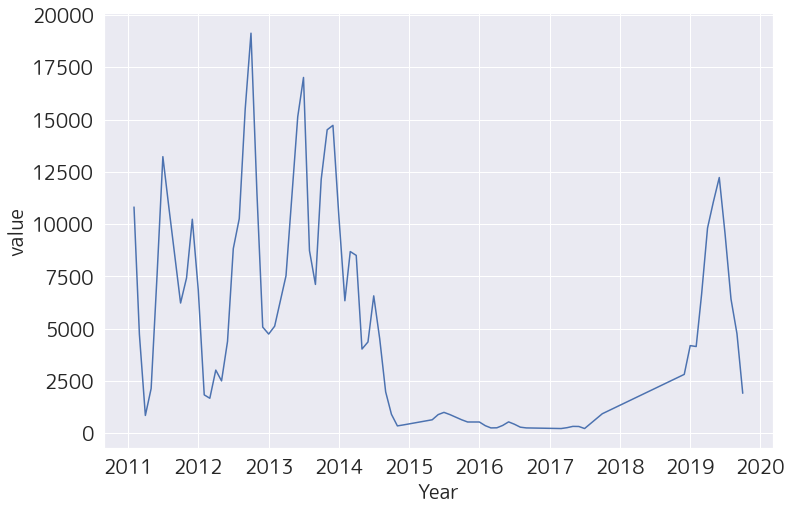

In [78]:
decomposition = seasonal_decompose(em_series_month, model='additive',period = 2)
plt.figure(figsize=(12,8))
plt.xticks(fontsize = 20, rotation = 0)
plt.yticks(fontsize = 20, rotation = 0)
plt.xlabel('Year',fontsize = 20)
plt.ylabel('value',fontsize = 20)
plt.plot(decomposition.trend)

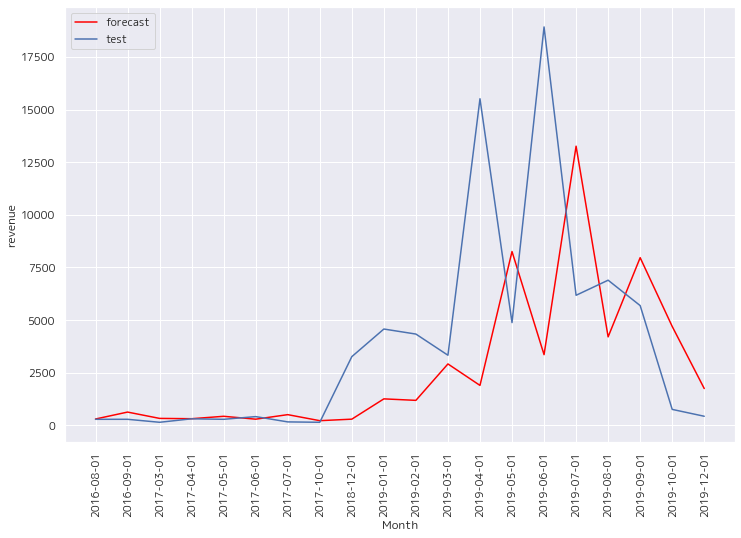

In [79]:
df_sum_month.reset_index(inplace=True)
df_sum_month['month_year'] = df_sum_month['month_year'].astype(str)
list_datetime = list(df_sum_month['month_year'][size:len(X)])
plt.figure(figsize=(12,8))
plt.plot(np.exp(predictions), color='red')
plt.xticks(rotation = 90)
plt.xlabel('Month')
plt.ylabel('revenue')
sns.lineplot(x=list_datetime,y='total_price',data=df_sum_month[size:len(X)])
plt.legend(loc='upper left', labels=['forecast','test'])


In [80]:
X = np.log(em_series_year).values
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# model = ARIMA(np.log(em_series_month), order=(5,1,0))
# results = model.fit()
# pred = results.predict(start='2017-01', dynamic=False)
# y_forecasted = np.exp(pred)
# y_truth = em_series_month['2017-01-01':]
# rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
# mape = mean_absolute_percentage_error(y_truth, y_forecasted)
# print('RMSE: %.3f' % rmse)
# print('MAPE: %.3f' % mape)
# # plot forecasts against actual outcomes
# plt.xticks(rotation = 90)
# plt.plot(y_forecasted,color='red')
# plt.plot(em_series_month)
# plt.show()
#walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(1,0,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))
# evaluate forecasts
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)
rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

predicted=6151.437971, expected=1443.850588
predicted=2210.423105, expected=3260.378235
predicted=4530.084538, expected=71480.385294
RMSE: 38753.953
MAPE: 1.506


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:218: RuntimeWarning: divide by zero encountered in true_divide
  loglike, sigma2 = kalm

In [81]:
import math
min_aic = math.inf
list_param = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
            mod = SARIMAX(em_series_year,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            if results.aic < min_aic:
                min_aic  = results.aic
                list_param.clear()
                list_param.append(param)
                list_param.append(param_seasonal)
print(min_aic,list_param)

NameError: name 'pdq' is not defined

In [82]:
mod =SARIMAX(em_series_month,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6512      0.103     -6.324      0.000      -0.853      -0.449
ma.S.L12      -1.0148      0.099    -10.274      0.000      -1.208      -0.821
sigma2      2.418e+07   2.16e-09   1.12e+16      0.000    2.42e+07    2.42e+07


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


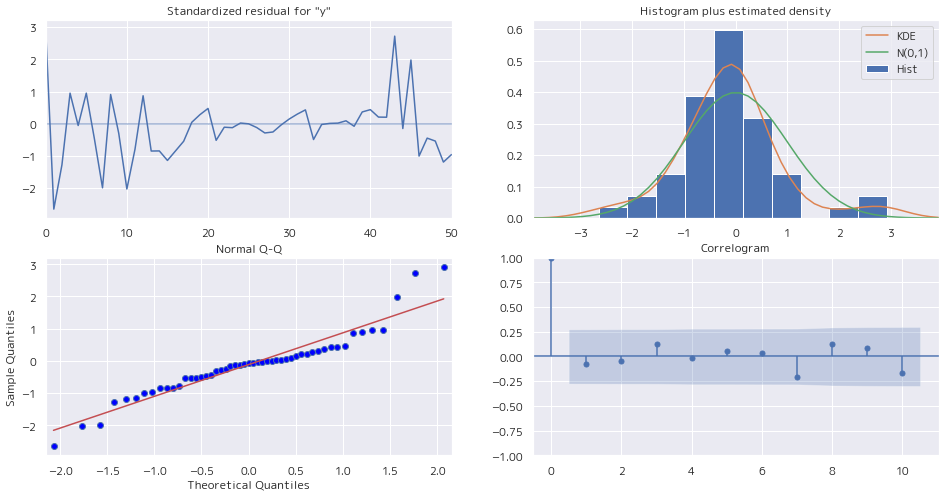

In [83]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

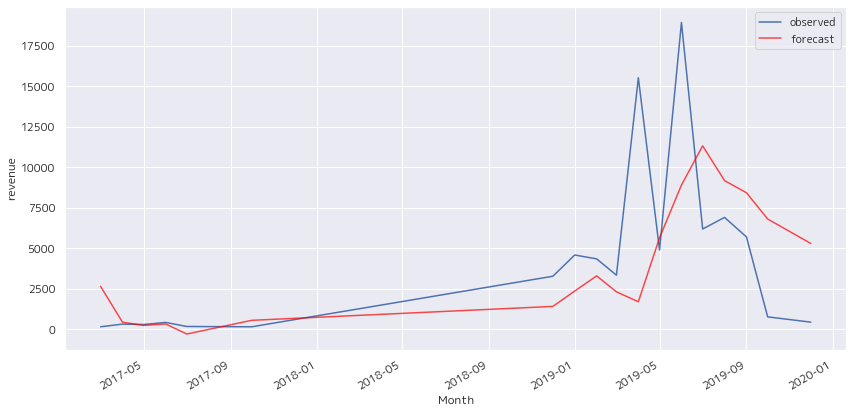

In [84]:
pred = results.get_prediction(start='2017-01', dynamic=False)
pred_ci = pred.conf_int()

ax = em_series_month['2017-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='forecast', color='red', alpha=.7, figsize=(14, 7))

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Month')
ax.set_ylabel('revenue')
plt.legend()

plt.show()

In [85]:
y_forecasted = pred.predicted_mean
y_truth = em_series_month['2017-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted,)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

RMSE: 4765.276
MAPE: 2.685


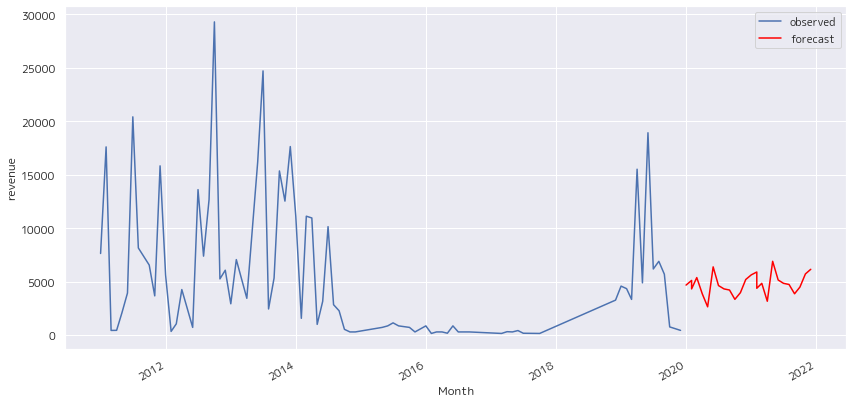

In [86]:
index = pd.to_datetime(['2020-01-01', '2020-02-01','2020-03-01','2020-02-01','2020-04-01','2020-05-01',
                        '2020-06-01','2020-07-01','2020-08-01','2020-09-01','2020-10-01','2020-11-01','2020-12-01',
                       '2021-01-01', '2021-02-01','2021-03-01','2021-02-01','2021-04-01','2021-05-01',
                        '2021-06-01','2021-07-01','2021-08-01','2021-09-01','2021-10-01','2021-11-01','2021-12-01'])
pred_uc = results.get_forecast(steps=len(index),index=index)
pred_ci = pred_uc.conf_int()
ax = em_series_month.plot(label='observed', figsize=(14, 7),)
pred_uc.predicted_mean.plot(ax=ax, label='forecast',color='red')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Month')
ax.set_ylabel('revenue')
plt.legend()
plt.show()

In [87]:
pred_uc.predicted_mean.to_frame()

,predicted_mean
2020-01-01,4668.774620
2020-02-01,5102.784936
2020-03-01,5370.330117
2020-02-01,4310.842044
2020-04-01,3846.296631
2020-05-01,2633.570751
2020-06-01,6371.605587
2020-07-01,4622.441940
2020-08-01,4309.621494
2020-09-01,4203.905466


In [108]:
mod =SARIMAX(em_series_year,
                                order=(1, 0, 0),
                                seasonal_order=(0, 0, 0, 2),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7870      0.227      3.464      0.001       0.342       1.232
sigma2      1.884e+09   7.23e-12    2.6e+20      0.000    1.88e+09    1.88e+09


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


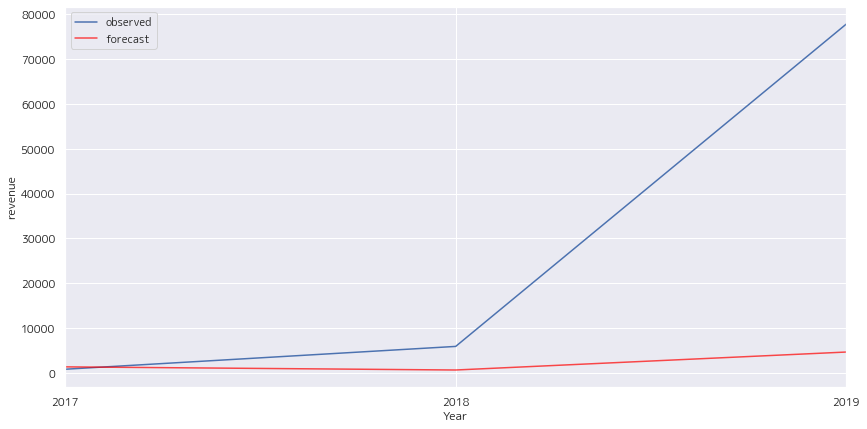

In [109]:
pred = results.get_prediction(start='2017-01-01', dynamic=False)
pred_ci = pred.conf_int()

ax = em_series_year['2017-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='forecast', color='red', alpha=.7, figsize=(14, 7))

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Year')
ax.set_ylabel('revenue')
plt.legend()

plt.show()

In [110]:
y_forecasted = pred.predicted_mean
y_truth = em_series_year['2017-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted,)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

RMSE: 42352.963
MAPE: 0.835


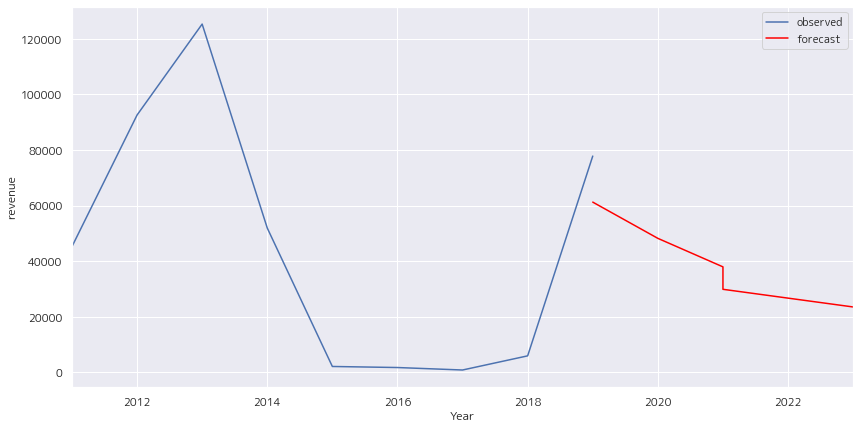

In [111]:
index = pd.to_datetime(['2019', '2020','2021','2021','2023'])
pred_uc = results.get_forecast(steps=len(index),index=index)
pred_ci = pred_uc.conf_int()
ax = em_series_year.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='forecast',color='red')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('revenue')
plt.legend()
plt.show()

In [112]:
pred_uc.predicted_mean.to_frame()

,predicted_mean
2019-01-01,61228.548491
2020-01-01,48186.357959
2021-01-01,37922.262581
2021-01-01,29844.504963
2023-01-01,23487.376962


# Engine Model FS

In [154]:
df_sum_day = df_1g.groupby(['Register Date'])['total_price'].sum().reset_index()
df_sum_month = df_1g.groupby(['month_year'])['total_price'].sum().reset_index()
df_sum_year = df_1g.groupby(['year'])['total_price'].sum().reset_index()
df_sum_month['month_year'] = pd.to_datetime(df_sum_month['month_year'],format='%Y-%m')
df_sum_month.set_index('month_year',inplace = True)
# df_sum_day['Register Date'] = df_sum_day['Register Date'].astype(str)
df_sum_year['year'] = pd.to_datetime(df_sum_year['year'],format='%Y')
em_series_month =  pd.Series(df_sum_month.total_price.values,index=df_sum_month.index)
em_series_year =  pd.Series(df_sum_year.total_price.values,index=df_sum_year['year'])
em_series = pd.Series(df_sum_day.total_price.values,index=df_sum_day['Register Date'])
em_series_sample = pd.Series(df_1g.total_price.values,index=df_1g['Register Date'])

In [155]:
len(train)

47

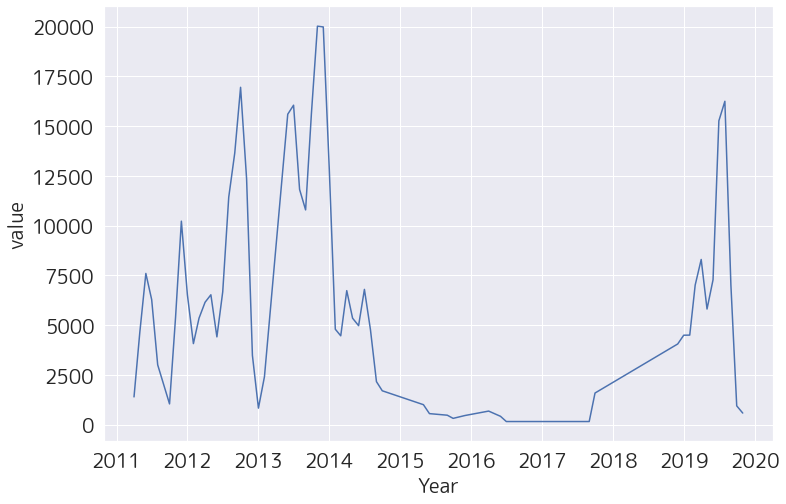

In [217]:
decomposition = seasonal_decompose(em_series_month, model='additive',period = 2)
plt.figure(figsize=(12,8))
plt.xticks(fontsize = 20, rotation = 0)
plt.yticks(fontsize = 20, rotation = 0)
plt.xlabel('Year',fontsize = 20)
plt.ylabel('value',fontsize = 20)
plt.plot(decomposition.trend)

In [178]:
X = np.log(em_series_month).values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(0,0,1))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))
# evaluate forecasts
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)
rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


predicted=2845.808582, expected=158.930833
predicted=1260.265135, expected=158.930833
predicted=1429.507880, expected=158.930833
predicted=1216.803881, expected=158.930833
predicted=1177.126047, expected=158.930833
predicted=1091.012316, expected=158.930833
predicted=1039.961910, expected=158.930833
predicted=985.092302, expected=158.930833
predicted=941.586129, expected=5888.577500
predicted=4177.528946, expected=4285.249167
predicted=2064.857574, expected=3524.469167
predicted=2551.450850, expected=6667.940000
predicted=3093.296571, expected=11195.877500
predicted=3643.858611, expected=4141.860833
predicted=2303.578586, expected=3765.225000
predicted=2693.154342, expected=17450.997500
predicted=4906.480781, expected=22395.120833
predicted=4447.571871, expected=2751.145833
predicted=1936.884885, expected=158.930833
predicted=781.675629, expected=713.930833
predicted=2151.381742, expected=750.010000
RMSE: 5596.684
MAPE: 3.811


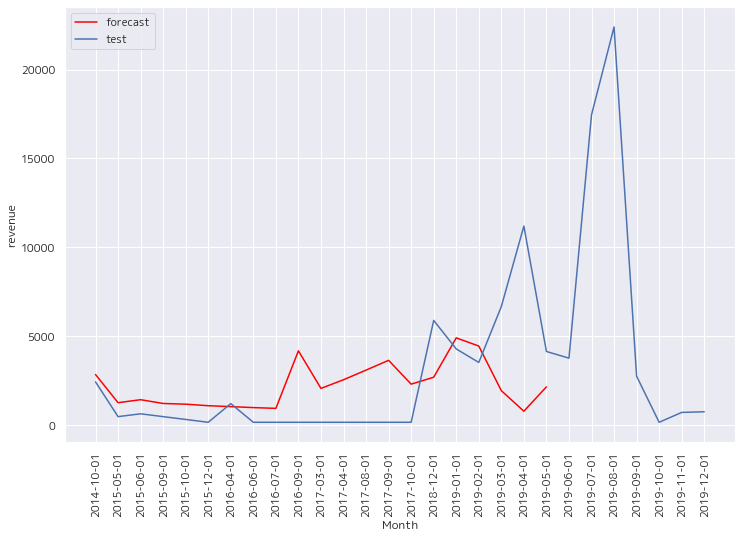

In [179]:
# df_sum_month.reset_index(inplace=True)
# df_sum_month['month_year'] = df_sum_month['month_year'].astype(str)
list_datetime = list(df_sum_month['month_year'][40:len(X)])
plt.figure(figsize=(12,8))
plt.plot(np.exp(predictions), color='red')
plt.xticks(rotation = 90)
plt.xlabel('Month')
plt.ylabel('revenue')
sns.lineplot(x=list_datetime,y='total_price',data=df_sum_month[40:len(X)])
plt.legend(loc='upper left', labels=['forecast','test'])

In [134]:
import math
min_aic = math.inf
list_param = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
            mod = SARIMAX(em_series_month,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            if results.aic < min_aic:
                min_aic  = results.aic
                list_param.clear()
                list_param.append(param)
                list_param.append(param_seasonal)
print(min_aic,list_param)

NameError: name 'pdq' is not defined

In [211]:
mod =SARIMAX(em_series_month,
                                order=(0, 0, 1),
                                seasonal_order=(1, 1, 1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5453      0.411      1.327      0.185      -0.260       1.351
ar.S.L12       0.3651      0.480      0.760      0.447      -0.576       1.306
ma.S.L12      -0.9862      0.407     -2.426      0.015      -1.783      -0.189
sigma2      8.717e+07   1.76e-09   4.97e+16      0.000    8.72e+07    8.72e+07


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


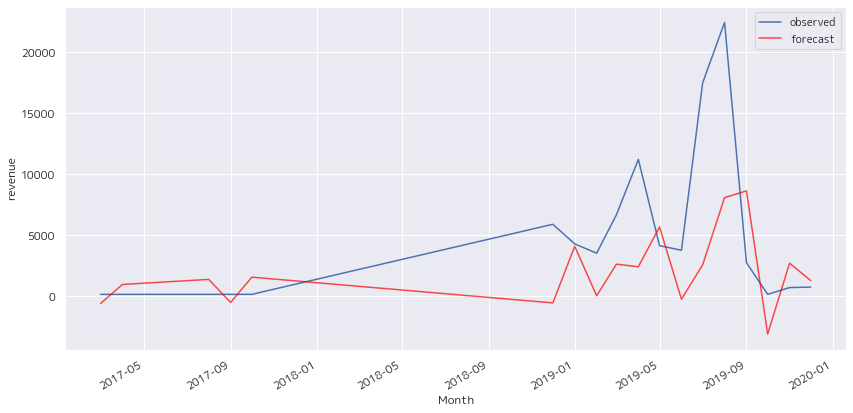

In [212]:
pred = results.get_prediction(start='2017-01', dynamic=False)
pred_ci = pred.conf_int()

ax = em_series_month['2017-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='forecast', color='red', alpha=.7, figsize=(14, 7))

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Month')
ax.set_ylabel('revenue')
plt.legend()

plt.show()

In [213]:
y_forecasted = pred.predicted_mean
y_truth = em_series_month['2017-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted,)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

RMSE: 5991.540
MAPE: 3.499


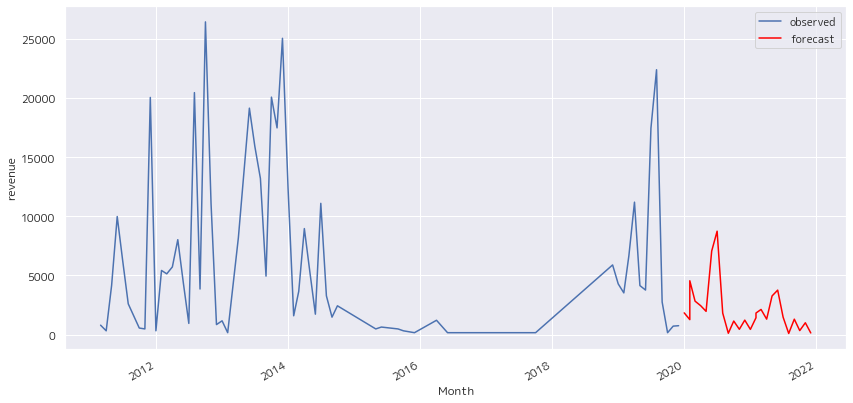

In [214]:
index = pd.to_datetime(['2020-01-01', '2020-02-01','2020-03-01','2020-02-01','2020-04-01','2020-05-01',
                        '2020-06-01','2020-07-01','2020-08-01','2020-09-01','2020-10-01','2020-11-01','2020-12-01',
                       '2021-01-01', '2021-02-01','2021-03-01','2021-02-01','2021-04-01','2021-05-01',
                        '2021-06-01','2021-07-01','2021-08-01','2021-09-01','2021-10-01','2021-11-01','2021-12-01'])
pred_uc = results.get_forecast(steps=len(index),index=index)
pred_ci = pred_uc.conf_int()
ax = em_series_month.plot(label='observed', figsize=(14, 7),)
pred_uc.predicted_mean.plot(ax=ax, label='forecast',color='red')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Month')
ax.set_ylabel('revenue')
plt.legend()
plt.show()

In [215]:
pred_uc.predicted_mean.to_frame()

,predicted_mean
2020-01-01,1834.845976
2020-02-01,1263.538822
2020-03-01,2826.142537
2020-02-01,4549.938961
2020-04-01,2442.004443
2020-05-01,1963.515473
2020-06-01,7060.565759
2020-07-01,8741.860824
2020-08-01,1816.088403
2020-09-01,112.129802


In [206]:
mod =SARIMAX(em_series_year,
                                order=(1, 0, 0),
                                seasonal_order=(0, 0, 0, 2),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7870      0.227      3.464      0.001       0.342       1.232
sigma2      1.884e+09   7.23e-12    2.6e+20      0.000    1.88e+09    1.88e+09


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


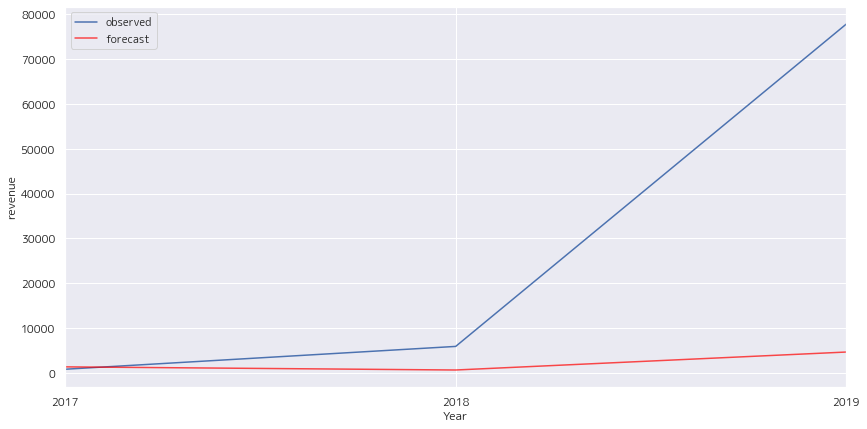

In [207]:
pred = results.get_prediction(start='2017-01-01', dynamic=False)
pred_ci = pred.conf_int()

ax = em_series_year['2017-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='forecast', color='red', alpha=.7, figsize=(14, 7))

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Year')
ax.set_ylabel('revenue')
plt.legend()

plt.show()

In [208]:
y_forecasted = pred.predicted_mean
y_truth = em_series_year['2017-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted,)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

RMSE: 42352.963
MAPE: 0.835


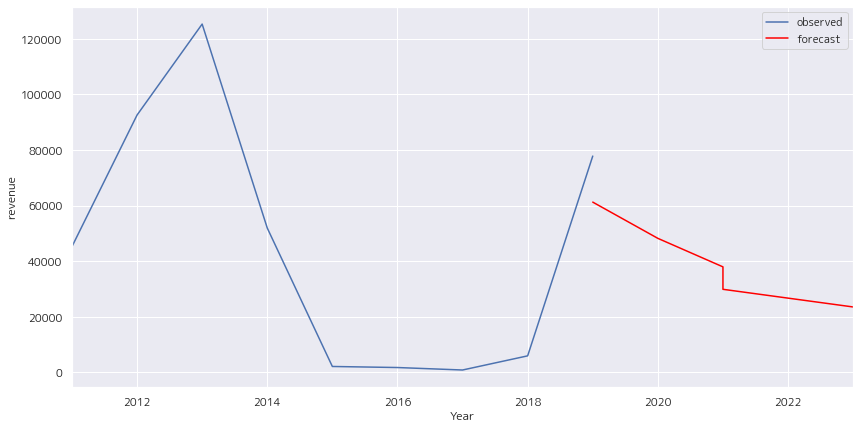

In [209]:
index = pd.to_datetime(['2019', '2020','2021','2021','2023'])
pred_uc = results.get_forecast(steps=len(index),index=index)
pred_ci = pred_uc.conf_int()
ax = em_series_year.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='forecast',color='red')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('revenue')
plt.legend()
plt.show()

In [210]:
pred_uc.predicted_mean.to_frame()

,predicted_mean
2019-01-01,61228.548491
2020-01-01,48186.357959
2021-01-01,37922.262581
2021-01-01,29844.504963
2023-01-01,23487.376962


# Engine Model FP

In [233]:
df_sum_day = df_fp.groupby(['Register Date'])['total_price'].sum().reset_index()
df_sum_month = df_fp.groupby(['month_year'])['total_price'].sum().reset_index()
df_sum_year = df_fp.groupby(['year'])['total_price'].sum().reset_index()
df_sum_month['month_year'] = pd.to_datetime(df_sum_month['month_year'],format='%Y-%m')
df_sum_month.set_index('month_year',inplace = True)
# df_sum_day['Register Date'] = df_sum_day['Register Date'].astype(str)
df_sum_year['year'] = pd.to_datetime(df_sum_year['year'],format='%Y')
em_series_month =  pd.Series(df_sum_month.total_price.values,index=df_sum_month.index)
em_series_year =  pd.Series(df_sum_year.total_price.values,index=df_sum_year['year'])
em_series = pd.Series(df_sum_day.total_price.values,index=df_sum_day['Register Date'])
em_series_sample = pd.Series(df_fp.total_price.values,index=df_fp['Register Date'])

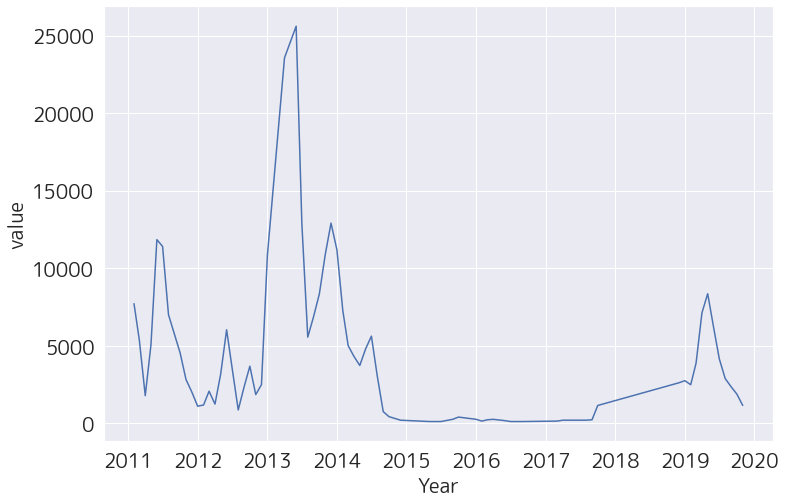

In [234]:
decomposition = seasonal_decompose(em_series_month, model='additive',period = 2)
plt.figure(figsize=(12,8))
plt.xticks(fontsize = 20, rotation = 0)
plt.yticks(fontsize = 20, rotation = 0)
plt.xlabel('Year',fontsize = 20)
plt.ylabel('value',fontsize = 20)
plt.plot(decomposition.trend)

In [235]:
X = np.log(em_series_month).values
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,0,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))
# evaluate forecasts
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)
rmse = mean_squared_error(np.exp(test), np.exp(predictions),squared=False)
mape = mean_absolute_percentage_error(np.exp(test), np.exp(predictions))
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


predicted=191.715357, expected=114.807692
predicted=174.518418, expected=229.615385
predicted=256.404924, expected=229.615385
predicted=247.304674, expected=114.807692
predicted=196.892211, expected=344.423077
predicted=376.261931, expected=114.807692
predicted=169.403054, expected=4026.680769
predicted=1403.172663, expected=2282.870769
predicted=851.873863, expected=2406.292308
predicted=2045.942540, expected=2855.455385
predicted=2118.043019, expected=7388.604615
predicted=3875.055940, expected=10879.056154
predicted=5198.469683, expected=4282.956154
predicted=3944.444837, expected=5310.355385
predicted=4892.926216, expected=1724.992308
predicted=2248.837514, expected=2772.964615
predicted=2823.447522, expected=2157.823077
predicted=2012.244670, expected=459.230769
predicted=926.702236, expected=1535.023077
RMSE: 2426.992
MAPE: 0.795


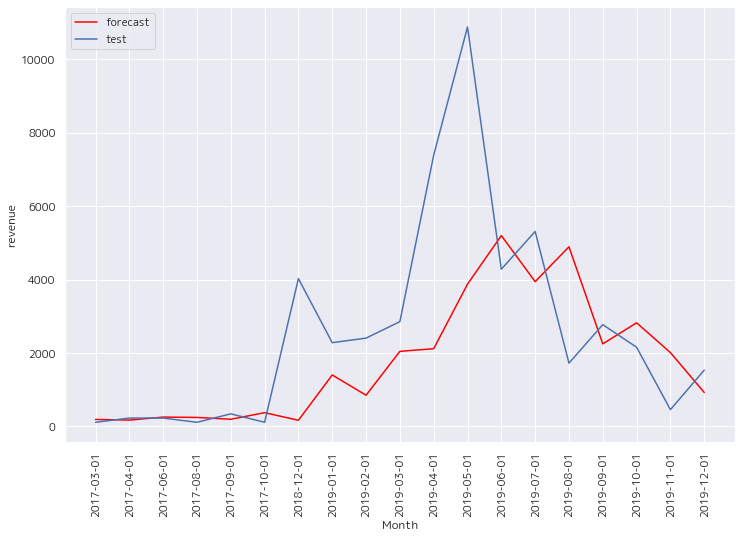

In [236]:
df_sum_month.reset_index(inplace=True)
df_sum_month['month_year'] = df_sum_month['month_year'].astype(str)
list_datetime = list(df_sum_month['month_year'][size:len(X)])
plt.figure(figsize=(12,8))
plt.plot(np.exp(predictions), color='red')
plt.xticks(rotation = 90)
plt.xlabel('Month')
plt.ylabel('revenue')
sns.lineplot(x=list_datetime,y='total_price',data=df_sum_month[size:len(X)])
plt.legend(loc='upper left', labels=['forecast','test'])

In [237]:
mod =SARIMAX(em_series_month,
                                order=(1, 1, 0),
                                seasonal_order=(1, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1348      0.070     -1.918      0.055      -0.272       0.003
ar.S.L12      -0.0218      0.137     -0.159      0.874      -0.291       0.247
sigma2      3.396e+07   2.24e-09   1.51e+16      0.000     3.4e+07     3.4e+07


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


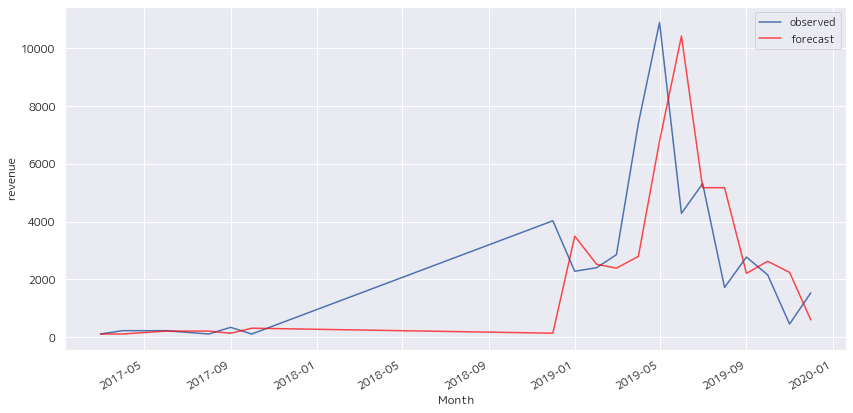

In [238]:
pred = results.get_prediction(start='2017-01', dynamic=False)
pred_ci = pred.conf_int()

ax = em_series_month['2017-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='forecast', color='red', alpha=.7, figsize=(14, 7))

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Month')
ax.set_ylabel('revenue')
plt.legend()

plt.show()

In [239]:
y_forecasted = pred.predicted_mean
y_truth = em_series_month['2017-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted,)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

RMSE: 2393.292
MAPE: 0.783


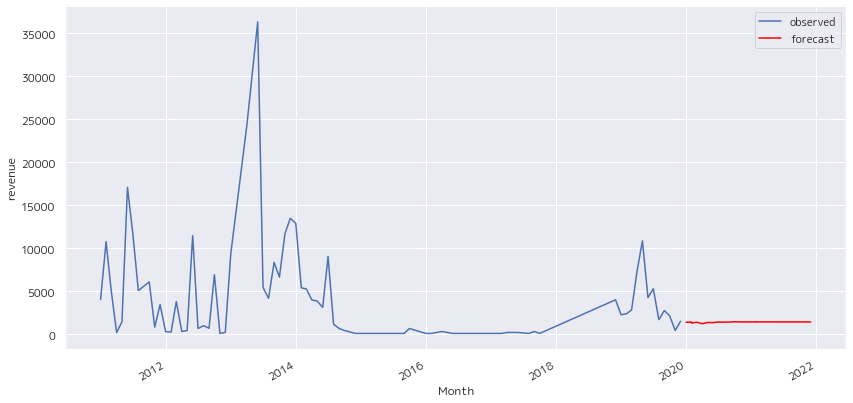

In [231]:
index = pd.to_datetime(['2020-01-01', '2020-02-01','2020-03-01','2020-02-01','2020-04-01','2020-05-01',
                        '2020-06-01','2020-07-01','2020-08-01','2020-09-01','2020-10-01','2020-11-01','2020-12-01',
                       '2021-01-01', '2021-02-01','2021-03-01','2021-02-01','2021-04-01','2021-05-01',
                        '2021-06-01','2021-07-01','2021-08-01','2021-09-01','2021-10-01','2021-11-01','2021-12-01'])
pred_uc = results.get_forecast(steps=len(index),index=index)
pred_ci = pred_uc.conf_int()
ax = em_series_month.plot(label='observed', figsize=(14, 7),)
pred_uc.predicted_mean.plot(ax=ax, label='forecast',color='red')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Month')
ax.set_ylabel('revenue')
plt.legend()
plt.show()

In [232]:
pred_uc.predicted_mean.to_frame()

,predicted_mean
2020-01-01,1416.565231
2020-02-01,1434.960519
2020-03-01,1422.329493
2020-02-01,1323.911944
2020-04-01,1247.785580
2020-05-01,1391.555232
2020-06-01,1369.162020
2020-07-01,1447.305515
2020-08-01,1424.464830
2020-09-01,1437.871907


In [240]:
mod =SARIMAX(em_series_year,
                                order=(1, 0, 0),
                                seasonal_order=(1, 0, 1, 2),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3994      6.880      0.058      0.954     -13.085      13.883
ar.S.L2       -0.0699    228.267     -0.000      1.000    -447.465     447.325
ma.S.L2       -0.0853    158.189     -0.001      1.000    -310.129     309.958
sigma2      1.736e+09   4.16e-06   4.17e+14      0.000    1.74e+09    1.74e+09


D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
D:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


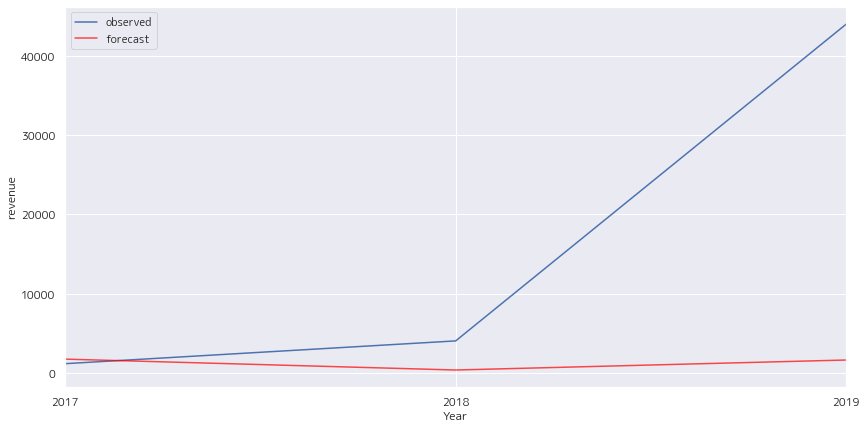

In [241]:
pred = results.get_prediction(start='2017-01-01', dynamic=False)
pred_ci = pred.conf_int()

ax = em_series_year['2017-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='forecast', color='red', alpha=.7, figsize=(14, 7))

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Year')
ax.set_ylabel('revenue')
plt.legend()

plt.show()

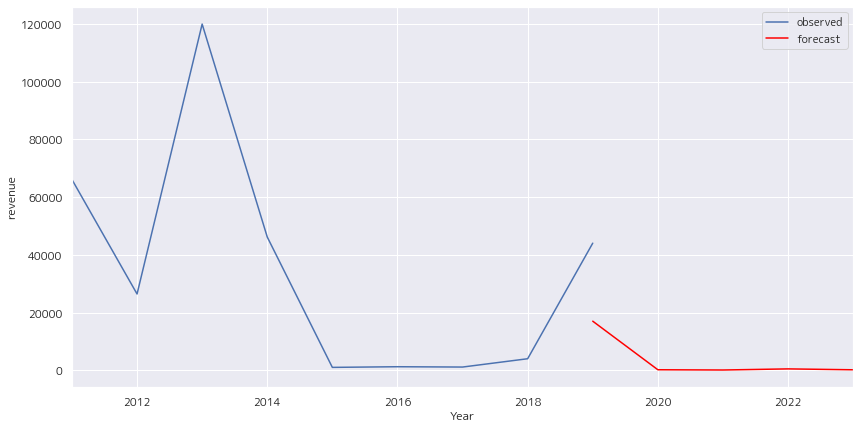

In [226]:
index = pd.to_datetime(['2019', '2020','2021','2022','2023'])
pred_uc = results.get_forecast(steps=len(index),index=index)
pred_ci = pred_uc.conf_int()
ax = em_series_year.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='forecast',color='red')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('revenue')
plt.legend()
plt.show()

In [227]:
y_forecasted = pred.predicted_mean
y_truth = em_series_year['2017-01-01':]
rmse = mean_squared_error(y_truth, y_forecasted,squared=False)
mape = mean_absolute_percentage_error(y_truth, y_forecasted,)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

RMSE: 24598.684
MAPE: 0.793


In [203]:
pred_uc.predicted_mean.to_frame()

,predicted_mean
2019-01-01,17032.341021
2020-01-01,214.057624
2021-01-01,124.865615
2022-01-01,510.503655
2023-01-01,201.138729
